# Project 8: Multi-factor Model
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages

In [1]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [2]:
# !pip install cvxpy

### Load Packages

In [3]:
# import cvxpy as cvx
import numpy as np
import pandas
import pandas as pd
import time
import scipy
# import project_tests
# import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [4]:
start_time = pd.Timestamp("2021-01-01 00:00:00")

risk_aversion = 1.0e-6

len_dates = 500
len_pca_dates = 500

max_symbol = 40

max_factors=5

### 导入数据

In [5]:
def get_data(symbol, n=None):
    """ Function which returns the data of the symbol"""

    data_df = pd.read_csv(data_path+"/"+symbol+".csv", parse_dates=['DateTime'])
    
    # TODO:改名 DateTime
    data_df = data_df.rename(columns={'DateTime':'datetime', 'Open':'open', 'Low':'low', 'High':'high', 'Close':'close', 'Volume':'volume'})
#     data_df["datetime"] = pd.to_datetime(data_df["datetime"], unit='ms')
    data_df = data_df.set_index('datetime')
    # 取倒数 n 行
    if n is not None:
        data_df = data_df.iloc[-n:]
        
    # 注意，原始数据是15min，这里resmaple成需要的周期。
    data_df = data_df.resample(rule=rule_type, label='left', closed='left').agg(
        {'open': 'first',
         'high': 'max',
         'low': 'min',
         'close': 'last',
         'volume': 'sum',
         })
    
    return data_df

In [6]:
# 数据长度
# TODO:
N_month = 12*3
N_daily_data = 4*24
data_len = N_month*30*N_daily_data
print("data len is ", data_len)

# data resample period
rule_type = '4H'
# 乘以4,代表一天4条数据。
target_data_len = N_month*30*6

data len is  103680


In [7]:

import os
data_path="data"
symbol_list=[]
dirs = os.listdir( data_path )

# 输出所有文件和文件夹
for file in dirs:
#     print(file)
    symbol_list.append(file[:-4])

print(symbol_list)


['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'APE_USDT', 'APT_USDT', 'AR_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'BNX_USDT', 'BTC_USDT', 'CELO_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'CVX_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'DYDX_USDT', 'EGLD_USDT', 'ENJ_USDT', 'ENS_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FLOW_USDT', 'FTM_USDT', 'GMT_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'ICP_USDT', 'IMX_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KLAY_USDT', 'KSM_USDT', 'LDO_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MASK_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'OP_USDT', 'QNT_USDT', 'QTUM_USDT', 'ROSE_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_USDT', 'ZIL_USDT']


In [8]:
small_price_thre = 0.00001
small_price_symbols=[]

short_data_symbols=[]

# raw_df = pd.DataFrame()
total_close_df=pd.DataFrame()


# 使用 BTC_USDT 作为初始化。
df = get_data("BTC_USDT", data_len).dropna()
total_close_df["BTC_USDT"] = df["close"].pct_change().fillna(0)

for symbol in symbol_list:
        df = get_data(symbol, data_len).dropna()
        # 过滤掉数据较少的
        if len(df) < target_data_len*0.5:
            short_data_symbols.append(symbol)
            continue
            
        total_close_df[symbol] = df["close"].pct_change().fillna(0)
        # 防止最后一行数据为Nan,所以取倒数第2行。
        if df["close"].iloc[-2] < small_price_thre:
            small_price_symbols.append(symbol)

In [9]:
### 去掉价格过小的品种
print("small price symbol", small_price_symbols)
print("short data symbol", short_data_symbols)
symbol_list = [symbol for symbol in symbol_list if symbol not in small_price_symbols]
symbol_list = [symbol for symbol in symbol_list if symbol not in short_data_symbols]
print("filtered symbol list ", symbol_list)

small price symbol []
short data symbol ['APE_USDT', 'APT_USDT', 'AR_USDT', 'BNX_USDT', 'CELO_USDT', 'CVX_USDT', 'DYDX_USDT', 'ENS_USDT', 'FLOW_USDT', 'GMT_USDT', 'ICP_USDT', 'IMX_USDT', 'KLAY_USDT', 'LDO_USDT', 'MASK_USDT', 'OP_USDT', 'QNT_USDT', 'ROSE_USDT']
filtered symbol list  ['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'BTC_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FTM_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KSM_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'QTUM_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_

In [10]:
total_close_df = total_close_df.fillna(0)
total_close_df

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 12:00:00,0.005122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 16:00:00,-0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 20:00:00,-0.003983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02 00:00:00,-0.009764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,-0.001479,-0.011687,-0.001567,-0.003482,-0.002903,-0.005459,-0.011097,-0.009029,-0.013550,-0.010336,...,0.014620,-0.000524,-0.001710,-0.006079,-0.008032,0.003721,-0.001007,-0.007944,0.000895,-0.002200
2022-12-01 20:00:00,0.001481,0.004927,-0.000785,-0.001588,0.002496,0.006273,-0.002012,0.004409,0.009858,0.006963,...,0.002712,-0.001572,0.003426,0.000000,-0.000912,0.009582,-0.000756,0.004004,0.005590,0.002646
2022-12-02 00:00:00,-0.004514,-0.018435,-0.008481,-0.006045,-0.014938,-0.008280,0.002947,-0.005706,0.001440,-0.008643,...,0.005917,-0.006824,0.006402,-0.012232,-0.009017,-0.004018,-0.024710,-0.004985,-0.005115,-0.004398


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [11]:
from sklearn.decomposition import PCA

class RiskModelPCA():
    
    ANN_FACTOR = 252
    
    def __init__(self, num_factors):
        self._num_factors = num_factors
        self.num_stocks_ = None
        self.factor_betas_ = None
        self.factor_returns_ = None
        self.common_returns_ = None
        self.residuals_ = None
        self.factor_cov_matrix_ = None
        self.idio_var_matrix_ = None
        self.explained_variance_ratio_ = None

    def fit(self, returns):
        self.num_stocks_ = len(returns.columns)
        mod = PCA(n_components=self._num_factors, svd_solver='full')
        mod.fit(returns)
        
        # (B) factor_beta 为components。
        self.factor_betas_ = pd.DataFrame(
            data=mod.components_.T,
            index=returns.columns
        )
        factor_betas_colnames = [ "pca_B_"+str(x) for x in risk_model.factor_betas_.columns.tolist()]
        # 转换pca的dataframe的列名为
        # {0: 'pca_B_0', 1: 'pca_B_1', 2: 'pca_B_2', 3: 'pca_B_3', 4: 'pca_B_4'}
        pca_colnames_dict = dict(zip(self.factor_betas_.columns.tolist(), factor_betas_colnames))
        self.factor_betas_.rename(pca_colnames_dict, axis='columns', inplace=True)
        
        # factor return
        self.factor_returns_ = pd.DataFrame(
            data=mod.transform(returns),
            index=returns.index
        )
        
        self.explained_variance_ratio_ = mod.explained_variance_ratio_
        
        self.common_returns_ = pd.DataFrame(
            data=np.dot(self.factor_returns_, self.factor_betas_.T),
            index=returns.index
        )
        self.common_returns_.columns = returns.columns
        
        self.residuals_ = (returns - self.common_returns_)
        
        # （F） factor covariance matrix. 为factor return的方差 * annual factor(252/365?)
        self.factor_cov_matrix_ = np.diag(
            self.factor_returns_.var(axis=0, ddof=1)*RiskModelPCA.ANN_FACTOR
        )
        
        # (S) idiosyncratic variance matrix. 
        self.idio_var_matrix_ = pd.DataFrame(
            data=np.diag(np.var(self.residuals_))*RiskModelPCA.ANN_FACTOR,
            index=returns.columns
        )
        
        #  idiosyncratic variance Vector
        # 把 idiosyncratic variance matrix 对角矩阵，提取对角上的元素，压缩成向量。
        # 也可以这样，idiosyncratic_var_vector = pd.DataFrame(np.max(idiosyncratic_var_matrix, axis=0))
        self.idio_var_vector_ = pd.DataFrame(
            data=np.diag(self.idio_var_matrix_.values),
            index=returns.columns
        )
        
        self.idio_var_matrix_.columns = index=returns.columns

    def get_factor_exposures(self, weights):
        B = self.factor_betas_.loc[weights.index]
        return B.T.dot(weights)

### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [12]:
num_factor_exposures = 5
risk_model = RiskModelPCA(num_factor_exposures) 

Let's also look at the PCA's percent of variance explained by each factor

In [13]:
risk_model.fit(total_close_df)

<BarContainer object of 5 artists>

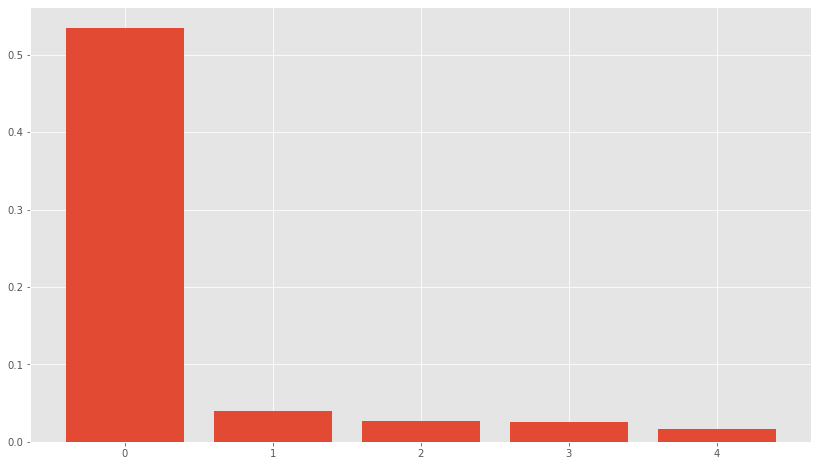

In [14]:
plt.bar(np.arange(num_factor_exposures), risk_model.explained_variance_ratio_)

Let's see what these factor returns looks like over time.

<AxesSubplot:xlabel='datetime'>

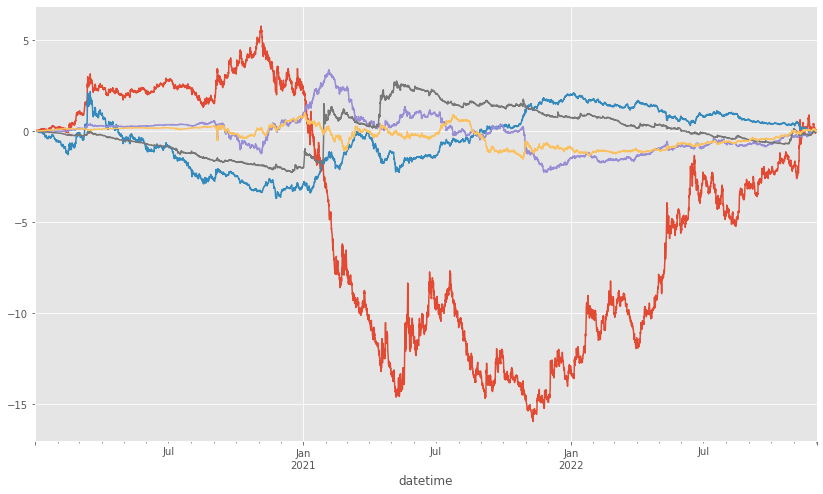

In [15]:
risk_model.factor_returns_.cumsum().plot(legend=None)

You will see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [16]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    # for some reason using multiplication operation * doesn't work even though broadcasting should handle that,
    # gotta resort to ugly np.dot implementation, would appreciate feedback on this
    predict_portfolio_risk = float(np.sqrt( np.dot(np.dot(weights.T,(np.dot(np.dot(factor_betas,factor_cov_matrix), factor_betas.T) + idiosyncratic_var_matrix)),weights)))
    
    return predict_portfolio_risk


# project_tests.test_predict_portfolio_risk(predict_portfolio_risk)

### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.
#### 这里假设使用平均的权重

In [17]:
len(symbol_list)

59

In [18]:
# all_weights = pd.DataFrame(np.repeat(1/len(symbol_list), len(symbol_list)), symbol_list)

# predict_portfolio_risk(
#     risk_model['factor_betas'],
#     risk_model['factor_cov_matrix'],
#     risk_model['idiosyncratic_var_matrix'],
#     all_weights)

## 因子计算

In [19]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

# pickle/csv在读写double/float类型数据时，可能发生精度的损失，导致符号计算错误。
# 使用自定义的sign，与c++一致。
import math
def mysign(x):
    if math.fabs(x)<1e-8:
        return 0
    elif x>0:
        return 1
    else:
        return -1
    
def ewma(x, halflife, init=0, adjust=False):
    # TODO: halflife 为 0时的默认取值。
    if halflife == 0:
        halflife = 1
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    if adjust:
        xx = range(len(x))
        lamb=1 - 0.5**(1 / halflife)
        aa=1-np.power(1-lamb, xx)*(1-lamb)
        bb=s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]
        return bb/aa
    else:
        return s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]

def get_range_pos(wpr, min_period, max_period, period):
    return zero_divide(wpr-min_period, max_period-min_period).rolling(period).mean() - 0.5

In [20]:
print(symbol_list)

['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'BTC_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FTM_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KSM_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'QTUM_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_USDT', 'ZIL_USDT']


In [21]:
# 把"BTC_USDT"移到开始
symbol_list.remove("BTC_USDT")
print(symbol_list)
symbol_list.insert(0, "BTC_USDT")
print(symbol_list)

['1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FTM_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'HOT_USDT', 'IOTA_USDT', 'KAVA_USDT', 'KSM_USDT', 'LINK_USDT', 'LRC_USDT', 'LTC_USDT', 'MANA_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'QTUM_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SUSHI_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XEM_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_USDT', 'ZIL_USDT']
['BTC_USDT', '1INCH_USDT', 'AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAL_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'CHZ_USDT', 'COMP_USDT', 'CRV_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'EOS_USDT', 'ETC_USDT', '

In [22]:
len(symbol_list)

59

**注意，return为相比前一天的return，next_return为未来一天的return**

**因子的名字不能包含".", 否则 patsy.dmatrices(formula, data) 提取因子矩阵的时候会报错**

In [23]:
# from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

factor_df = {}

# for symbol in tqdm(symbol_list):
for symbol in symbol_list:
    print(symbol)
    
    
    # Import the data
    df = get_data(symbol, data_len).dropna()
    
    # return 为相比上一次价格的涨幅比例
    df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)
    
    # 注意，next return 为 未来数据。
    df["next_returns"] = df["returns"].shift(-1)
   

    period=20
    df["nr"] = zero_divide(ewma(df["returns"], period, adjust=True), ewma(df["returns"].abs(), period, adjust=True)).shift(1)
#     df["nr"] = zero_divide(df[["return"]].rolling(period).mean(), df[["return"]].abs().rolling(period).mean()).shift(1)
    
    # vol diff
#     df["dbook"] = df[["volume"]].pct_change(1).rolling(period).mean().shift(1)
    vol_diff = zero_divide(df["volume"] - df["volume"].shift(1), df["volume"].shift(1))
    df["dbook"] = vol_diff.rolling(period).mean().shift(1)
    
    # range_pos
    rolling_max = df["close"].rolling(period).max()
    rolling_min = df["close"].rolling(period).min()
    
    df["range_pos"] = get_range_pos(df["close"], rolling_min, rolling_max, period).shift(1)
    df["price_osci"] = zero_divide(ewma(df["close"], round(period/20), adjust=True)-ewma(df["close"], period, adjust=True), 
                                   rolling_max-rolling_min).shift(1)
    

    # ma_diff
    df["ma_dif"] = zero_divide(ewma(df["close"], round(period/10), adjust=True) - ewma(df["close"], period, adjust=True), df["close"]).shift(1)

    # KDF
    df["kdj_k"] = ewma((zero_divide(df["close"]-rolling_min, rolling_max-rolling_min)-0.5)*2, round(period/5), adjust=True).shift(1)
    df["kdj_j"] = ewma(ewma((zero_divide(df["close"]-rolling_min, rolling_max-rolling_min)-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).shift(1)

    # range index
    df["std"] = df["close"].rolling(period).std().shift(1)
    df["range"] = (rolling_max - rolling_min).shift(1)
    
    df["trend_index"] = zero_divide(abs(df["close"]-df["close"].shift(period)), rolling_max-rolling_min)    
    df["trend_index"][0:period]=0
    df["trend_index"] = df["trend_index"].shift(1)
    
    # 组合index
    dire_signal_list = ["nr", "dbook", "range_pos", "price_osci", "ma_dif", "kdj_k", "kdj_j"]
    range_signal_list = ["", "range", "std", "trend_index"]
    all_signal_list = np.array([])
    for range_signal in range_signal_list:
        for dire_signal in dire_signal_list:
            if len(range_signal)==0:
                signal_name = dire_signal
            else:
                signal_name = dire_signal+"__"+range_signal
                df[signal_name] = df[dire_signal] * df[range_signal]
    
    
    
    factor_df[symbol] = df
    

BTC_USDT
1INCH_USDT
AAVE_USDT
ADA_USDT
ALGO_USDT
ATOM_USDT
AVAX_USDT
AXS_USDT
BAL_USDT
BAT_USDT
BCH_USDT
BNB_USDT
CHZ_USDT
COMP_USDT
CRV_USDT
DASH_USDT
DOGE_USDT
DOT_USDT
EGLD_USDT
ENJ_USDT
EOS_USDT
ETC_USDT
ETH_USDT
FIL_USDT
FTM_USDT
GRT_USDT
HBAR_USDT
HNT_USDT
HOT_USDT
IOTA_USDT
KAVA_USDT
KSM_USDT
LINK_USDT
LRC_USDT
LTC_USDT
MANA_USDT
MATIC_USDT
MKR_USDT
NEAR_USDT
NEO_USDT
QTUM_USDT
RUNE_USDT
RVN_USDT
SAND_USDT
SNX_USDT
SOL_USDT
SUSHI_USDT
THETA_USDT
TRX_USDT
UNI_USDT
VET_USDT
WAVES_USDT
XEM_USDT
XLM_USDT
XMR_USDT
XRP_USDT
XTZ_USDT
ZEC_USDT
ZIL_USDT


In [24]:
df.head()

,open,high,low,close,volume,returns,next_returns,nr,dbook,range_pos,...,ma_dif__std,kdj_k__std,kdj_j__std,nr__trend_index,dbook__trend_index,range_pos__trend_index,price_osci__trend_index,ma_dif__trend_index,kdj_k__trend_index,kdj_j__trend_index
datetime,,,,,,,,,,,,,,,,,,,,,
2020-06-18 08:00:00,0.02270,0.02270,0.02086,0.02194,187937067.0,NaN,-0.022789,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-18 12:00:00,0.02194,0.02200,0.02100,0.02144,136667112.0,-0.022789,-0.018657,0.0,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2020-06-18 16:00:00,0.02144,0.02158,0.02082,0.02104,88497620.0,-0.018657,-0.009506,-1.0,NaN,NaN,...,NaN,NaN,NaN,-0.0,NaN,NaN,NaN,-0.0,0.0,0.0
2020-06-18 20:00:00,0.02104,0.02125,0.02020,0.02084,152405492.0,-0.009506,0.021113,-1.0,NaN,NaN,...,NaN,NaN,NaN,-0.0,NaN,NaN,NaN,-0.0,0.0,0.0
2020-06-19 00:00:00,0.02087,0.02188,0.02030,0.02128,157070490.0,0.021113,0.007519,-1.0,NaN,NaN,...,NaN,NaN,NaN,-0.0,NaN,NaN,NaN,-0.0,0.0,0.0


In [25]:
factor_df

{'BTC_USDT':                          open      high       low     close     volume  \
 datetime                                                                 
 2020-01-01 08:00:00   7195.23   7234.57   7181.43   7192.65   6650.944   
 2020-01-01 12:00:00   7192.74   7260.43   7191.79   7229.49  11010.528   
 2020-01-01 16:00:00   7229.66   7248.00   7210.81   7226.35   7787.862   
 2020-01-01 20:00:00   7226.56   7242.00   7174.00   7197.57  10172.536   
 2020-01-02 00:00:00   7197.57   7209.59   7121.00   7127.29  13363.900   
 ...                       ...       ...       ...       ...        ...   
 2022-12-01 16:00:00  16970.50  16991.70  16893.10  16945.40  49083.591   
 2022-12-01 20:00:00  16945.50  16982.40  16851.20  16970.50  36309.276   
 2022-12-02 00:00:00  16970.50  17038.00  16852.40  16893.90  50361.076   
 2022-12-02 04:00:00  16893.90  16967.20  16874.00  16947.10  26262.365   
 2022-12-02 08:00:00  16947.00  16962.70  16925.30  16957.50   6862.131   
 
           

In [26]:
factor_1_df=pd.DataFrame()
factor_name="price_osci"
for symbol in symbol_list:
#     print(symbol)
    factor_1_df[symbol] = factor_df[symbol][factor_name]
    
factor_1_df

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.386976,-0.310182,0.456295,0.056602,-0.271226,0.253610,0.270537,0.150297,0.599520,0.226169,...,0.359186,0.175134,0.405101,0.209766,-0.126321,0.571357,0.212115,0.237529,0.494061,0.223424
2022-12-01 20:00:00,0.335344,-0.500038,0.413659,0.009048,-0.334573,0.166595,0.188754,0.084611,0.512777,0.116204,...,0.390385,0.166917,0.350249,0.266506,-0.256035,0.567279,0.180298,0.162182,0.506964,0.207813
2022-12-02 00:00:00,0.338795,-0.538466,0.453983,-0.035591,-0.393539,0.188316,0.151466,0.091500,0.508514,0.115513,...,0.436847,0.154133,0.354697,0.208322,-0.362969,0.625906,0.181392,0.177327,0.532619,0.253882


#### 因子取极值

In [27]:
def winsorize(df):
    # 截断与中位数相距5个[离差中位数]以上的数值
    new_data=[]
    for i in range(len(df)):
        
        # 按行取，即每个时间点（每天，每小时等）的横截面的均值。
        df_i = df.iloc[i, :]
        df_i_median = df_i.median()
        # 每个数据偏离均值的差的均值
        mad = (df_i - df_i_median).abs().median()
        
        max_range = df_i_median + 5 * mad
        min_range = df_i_median - 5 * mad
        df_i_new = np.clip(df_i, min_range, max_range)
        
        new_data.append(df_i_new)
        
    new_df = pd.concat(new_data, axis=1).T
    return new_df

In [28]:
factor_1_df = winsorize(factor_1_df)
factor_1_df

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.386976,-0.310182,0.456295,0.056602,-0.271226,0.253610,0.270537,0.150297,0.599520,0.226169,...,0.359186,0.175134,0.405101,0.209766,-0.126321,0.571357,0.212115,0.237529,0.494061,0.223424
2022-12-01 20:00:00,0.335344,-0.500038,0.413659,0.009048,-0.334573,0.166595,0.188754,0.084611,0.512777,0.116204,...,0.390385,0.166917,0.350249,0.266506,-0.256035,0.567279,0.180298,0.162182,0.506964,0.207813
2022-12-02 00:00:00,0.338795,-0.538466,0.453983,-0.035591,-0.393539,0.188316,0.151466,0.091500,0.508514,0.115513,...,0.436847,0.154133,0.354697,0.208322,-0.362969,0.625906,0.181392,0.177327,0.532619,0.253882
2022-12-02 04:00:00,0.285502,-0.571006,0.378955,-0.129860,-0.559015,0.134262,0.140461,0.048722,0.517294,0.046843,...,0.470810,0.080731,0.420003,-0.009701,-0.474913,0.613573,-0.033794,0.119881,0.536804,0.239160


In [29]:
factor_1_df.T.describe()

,2020-01-01 08:00:00,2020-01-01 12:00:00,2020-01-01 16:00:00,2020-01-01 20:00:00,2020-01-02 00:00:00,2020-01-02 04:00:00,2020-01-02 08:00:00,2020-01-02 12:00:00,2020-01-02 16:00:00,2020-01-02 20:00:00,...,2022-11-30 20:00:00,2022-12-01 00:00:00,2022-12-01 04:00:00,2022-12-01 08:00:00,2022-12-01 12:00:00,2022-12-01 16:00:00,2022-12-01 20:00:00,2022-12-02 00:00:00,2022-12-02 04:00:00,2022-12-02 08:00:00
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.267185,0.329102,0.323482,0.275259,0.272146,0.233859,0.180096,0.176488,0.115837,0.156086
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.285482,0.251075,0.245384,0.251176,0.250489,0.265691,0.316738,0.358285,0.390531,0.430276
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.655968,-0.491180,-0.514167,-0.557811,-0.474437,-0.478456,-0.815275,-0.931217,-1.106214,-1.202292
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.121942,0.185118,0.199389,0.171838,0.171155,0.105053,0.062746,0.045480,-0.058810,-0.111464
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.247257,0.340949,0.316337,0.272661,0.277632,0.242737,0.189442,0.188316,0.140461,0.200083
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.473331,0.507407,0.500738,0.461409,0.451808,0.396038,0.407246,0.442647,0.403406,0.450673
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.822210,0.848328,0.785615,0.675927,0.700635,0.669925,0.763161,0.884629,1.040252,1.177362


#### 标准化
转换成均值为0，方差为1

In [30]:
def standardize(df):
    new_data = []
    for i in range(len(df)):
        df_i = df.iloc[i, :]
        mu = df_i.mean()
        sigma = df_i.std()
        df_i_new = (df_i - mu)/sigma
        new_data.append(df_i_new)
        
    new_df = pd.concat(new_data, axis=1).T
    return new_df

In [31]:
factor_1_df = standardize(factor_1_df)

In [32]:
factor_1_df.T.describe()

,2020-01-01 08:00:00,2020-01-01 12:00:00,2020-01-01 16:00:00,2020-01-01 20:00:00,2020-01-02 00:00:00,2020-01-02 04:00:00,2020-01-02 08:00:00,2020-01-02 12:00:00,2020-01-02 16:00:00,2020-01-02 20:00:00,...,2022-11-30 20:00:00,2022-12-01 00:00:00,2022-12-01 04:00:00,2022-12-01 08:00:00,2022-12-01 12:00:00,2022-12-01 16:00:00,2022-12-01 20:00:00,2022-12-02 00:00:00,2022-12-02 04:00:00,2022-12-02 08:00:00
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.774242e-17,4.045728e-17,-6.529617e-16,-1.797056e-16,-2.521523e-16,2.011103e-16,8.773584e-17,1.034954e-17,-9.408670e-19,9.126410e-17
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.233669e+00,-3.267074e+00,-3.413630e+00,-3.316679e+00,-2.980499e+00,-2.680991e+00,-3.142566e+00,-3.091688e+00,-3.129206e+00,-3.156989e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.087626e-01,-5.734696e-01,-5.057100e-01,-4.117488e-01,-4.031756e-01,-4.847962e-01,-3.704980e-01,-3.656535e-01,-4.472063e-01,-6.218079e-01
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.980528e-02,4.718456e-02,-2.912029e-02,-1.034438e-02,2.190214e-02,3.341521e-02,2.950560e-02,3.301345e-02,6.305299e-02,1.022538e-01
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.221004e-01,7.101645e-01,7.223621e-01,7.411145e-01,7.172439e-01,6.104067e-01,7.171514e-01,7.428708e-01,7.363525e-01,6.846485e-01
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.944172e+00,2.068004e+00,1.883306e+00,1.595169e+00,1.710610e+00,1.641255e+00,1.840839e+00,1.976476e+00,2.367072e+00,2.373538e+00


#### 缺失值处理(0填充)

In [33]:
factor_1_df = factor_1_df.fillna(0)
factor_1_df.T.describe()

,2020-01-01 08:00:00,2020-01-01 12:00:00,2020-01-01 16:00:00,2020-01-01 20:00:00,2020-01-02 00:00:00,2020-01-02 04:00:00,2020-01-02 08:00:00,2020-01-02 12:00:00,2020-01-02 16:00:00,2020-01-02 20:00:00,...,2022-11-30 20:00:00,2022-12-01 00:00:00,2022-12-01 04:00:00,2022-12-01 08:00:00,2022-12-01 12:00:00,2022-12-01 16:00:00,2022-12-01 20:00:00,2022-12-02 00:00:00,2022-12-02 04:00:00,2022-12-02 08:00:00
count,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0,...,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01,5.900000e+01
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.774242e-17,4.045728e-17,-6.529617e-16,-1.797056e-16,-2.521523e-16,2.011103e-16,8.773584e-17,1.034954e-17,-9.408670e-19,9.126410e-17
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-3.233669e+00,-3.267074e+00,-3.413630e+00,-3.316679e+00,-2.980499e+00,-2.680991e+00,-3.142566e+00,-3.091688e+00,-3.129206e+00,-3.156989e+00
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.087626e-01,-5.734696e-01,-5.057100e-01,-4.117488e-01,-4.031756e-01,-4.847962e-01,-3.704980e-01,-3.656535e-01,-4.472063e-01,-6.218079e-01
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.980528e-02,4.718456e-02,-2.912029e-02,-1.034438e-02,2.190214e-02,3.341521e-02,2.950560e-02,3.301345e-02,6.305299e-02,1.022538e-01
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.221004e-01,7.101645e-01,7.223621e-01,7.411145e-01,7.172439e-01,6.104067e-01,7.171514e-01,7.428708e-01,7.363525e-01,6.846485e-01
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.944172e+00,2.068004e+00,1.883306e+00,1.595169e+00,1.710610e+00,1.641255e+00,1.840839e+00,1.976476e+00,2.367072e+00,2.373538e+00


#### 预处理函数合并

In [34]:
def preprocess(df):
#     return standardize(winsorize(df)).fillna(0)
    return standardize(winsorize(df))

factor_processed=preprocess(factor_1_df)
# factor_processed.T.describe()

In [35]:
factor_processed

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.576296,-2.047648,0.837200,-0.667157,-1.901024,0.074339,0.138050,-0.314509,1.376267,-0.028942,...,0.471702,-0.221026,0.644517,-0.090682,-1.355636,1.270266,-0.081838,0.013813,0.979342,-0.039274
2022-12-01 20:00:00,0.490144,-2.147308,0.737398,-0.540030,-1.624906,-0.042628,0.027334,-0.301464,1.050331,-0.201719,...,0.663920,-0.041610,0.537202,0.272810,-1.376945,1.222405,0.000636,-0.056560,1.031979,0.087506
2022-12-02 00:00:00,0.453012,-1.995491,0.774509,-0.591927,-1.590988,0.033013,-0.069839,-0.237207,0.926710,-0.170187,...,0.726682,-0.062395,0.497396,0.088852,-1.505664,1.254360,0.013688,0.002341,0.993988,0.216011
2022-12-02 04:00:00,0.434446,-1.758742,0.673744,-0.629136,-1.728038,0.047179,0.063053,-0.171857,1.027976,-0.176667,...,0.908949,-0.089895,0.778853,-0.321456,-1.512685,1.274512,-0.383149,0.010355,1.077935,0.315782


### 因子IC分析
IC的定义
$$IC = corr(d_t, R_{t+1})$$
其中，$d_t$ 为所有个股$t$期的因子暴露向量，$R_{t+1}$为$t+1$期的收益率向量

In [36]:
# 因子值
factor_processed

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
2020-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.576296,-2.047648,0.837200,-0.667157,-1.901024,0.074339,0.138050,-0.314509,1.376267,-0.028942,...,0.471702,-0.221026,0.644517,-0.090682,-1.355636,1.270266,-0.081838,0.013813,0.979342,-0.039274
2022-12-01 20:00:00,0.490144,-2.147308,0.737398,-0.540030,-1.624906,-0.042628,0.027334,-0.301464,1.050331,-0.201719,...,0.663920,-0.041610,0.537202,0.272810,-1.376945,1.222405,0.000636,-0.056560,1.031979,0.087506
2022-12-02 00:00:00,0.453012,-1.995491,0.774509,-0.591927,-1.590988,0.033013,-0.069839,-0.237207,0.926710,-0.170187,...,0.726682,-0.062395,0.497396,0.088852,-1.505664,1.254360,0.013688,0.002341,0.993988,0.216011
2022-12-02 04:00:00,0.434446,-1.758742,0.673744,-0.629136,-1.728038,0.047179,0.063053,-0.171857,1.027976,-0.176667,...,0.908949,-0.089895,0.778853,-0.321456,-1.512685,1.274512,-0.383149,0.010355,1.077935,0.315782


In [37]:
# 下一期的收益率。
tmr_ret = total_close_df.shift(-1)
tmr_ret

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,0.005122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 12:00:00,-0.000434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 16:00:00,-0.003983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 20:00:00,-0.009764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02 00:00:00,-0.002768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,0.001481,0.004927,-0.000785,-0.001588,0.002496,0.006273,-0.002012,0.004409,0.009858,0.006963,...,0.002712,-0.001572,0.003426,0.000000,-0.000912,0.009582,-0.000756,0.004004,0.005590,0.002646
2022-12-01 20:00:00,-0.004514,-0.018435,-0.008481,-0.006045,-0.014938,-0.008280,0.002947,-0.005706,0.001440,-0.008643,...,0.005917,-0.006824,0.006402,-0.012232,-0.009017,-0.004018,-0.024710,-0.004985,-0.005115,-0.004398
2022-12-02 00:00:00,0.003149,-0.003796,-0.001109,0.003841,0.014322,0.002456,0.008737,0.007504,-0.009108,0.009154,...,-0.003361,0.008985,0.016539,0.003096,0.007602,0.003130,0.009307,0.014028,0.011399,0.005742


In [38]:
# 注意，一定要确保因子值与明日收益率的shape一样。
print(tmr_ret.shape)
print(factor_processed.shape)

(6397, 59)
(6397, 59)


### 计算IC值

<AxesSubplot:>

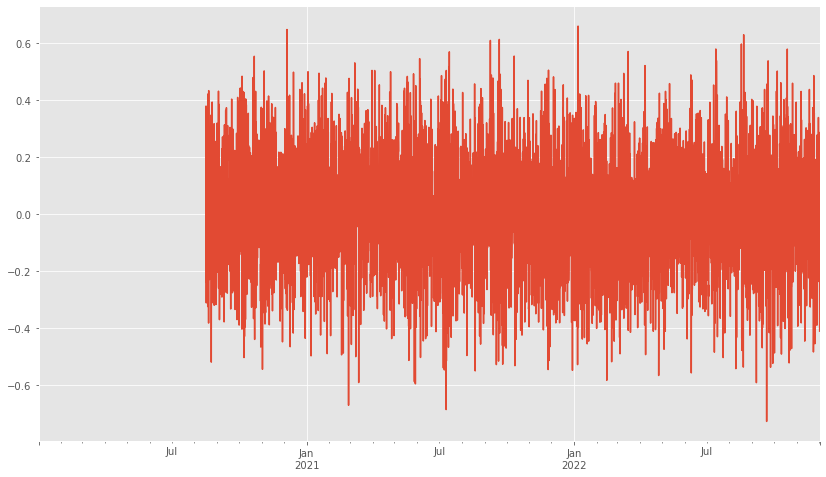

In [39]:
# axis=1，代表对每行求相关系数。这里设为1，代表按行，每行代表每一天，所以这里根据每天求相关系数。
IC_series = factor_processed.corrwith(tmr_ret, axis=1)
IC_series.plot()

In [40]:
IC_series.mean() / IC_series.std()

0.03918076000839485

<AxesSubplot:>

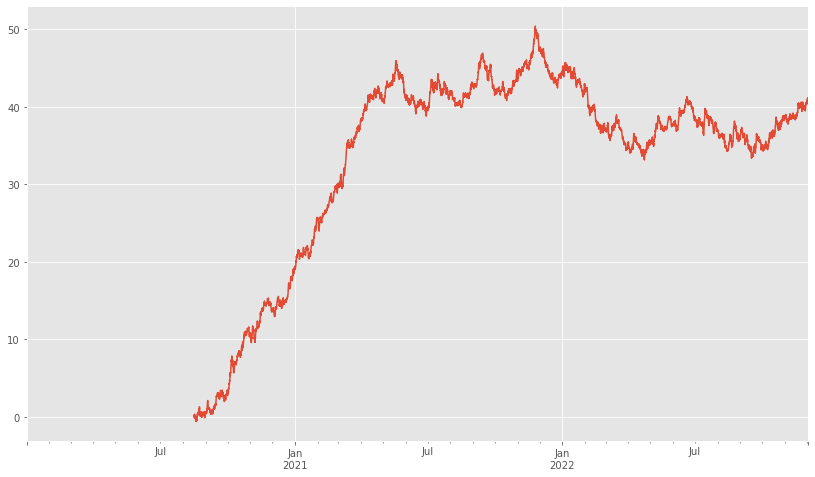

In [41]:
IC_series.cumsum().plot() #累计曲线能看出趋势

### Rank IC
Rank IC: 对因子值与明天收益率求rank，然后计算相关系数。
两个变量分别求排名rank，再计算2个rank的相关系数教Spearman相关系数。

In [42]:
 tmr_ret.iloc[:-1,0]

datetime
2020-01-01 08:00:00    0.005122
2020-01-01 12:00:00   -0.000434
2020-01-01 16:00:00   -0.003983
2020-01-01 20:00:00   -0.009764
2020-01-02 00:00:00   -0.002768
                         ...   
2022-12-01 12:00:00   -0.001479
2022-12-01 16:00:00    0.001481
2022-12-01 20:00:00   -0.004514
2022-12-02 00:00:00    0.003149
2022-12-02 04:00:00    0.000614
Freq: 4H, Name: BTC_USDT, Length: 6396, dtype: float64

In [43]:
# from scipy.stats.stats import pearsonr
# pearsonr(factor_processed.iloc[:-1,0], tmr_ret.iloc[:-1,0])

<AxesSubplot:>

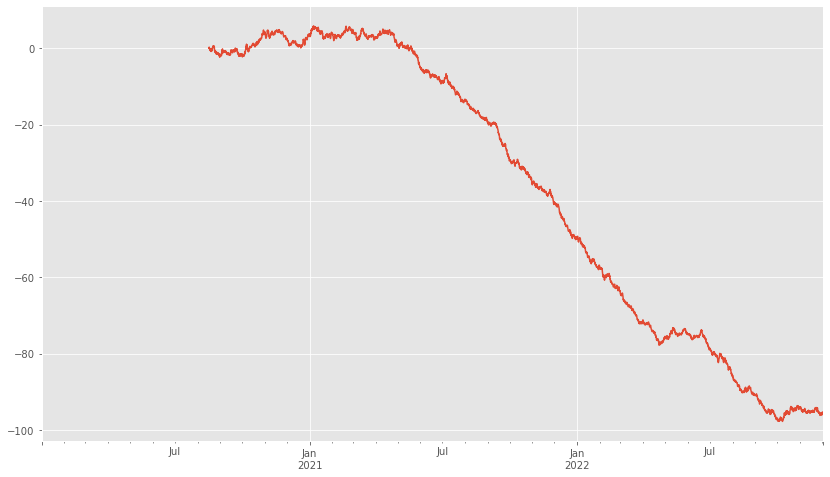

In [44]:
rank_IC_series = factor_processed.corrwith(tmr_ret, axis=1,
                                          method='spearman')
rank_IC_series.cumsum().plot()

### IR 和 胜率
IR: Information Ratio, IC的均值与标准差的比值，衡量IC稳定性。

胜率：IC 大于0的比率，与 0.5 相差越多越好。(因子无效时，即有时IC>0有时IC<0，此时胜率为0.5。若因子有效，则胜率远离0.5)

In [45]:
IR = rank_IC_series.mean() / rank_IC_series.std()
print(f"IR: {IR}")
    
win_rate = (rank_IC_series > 0).sum() / rank_IC_series.count()
print(f"win rate: {win_rate}")

IR: -0.09998974526093646
win rate: 0.4638949671772429


### 分层测试
每一层要能区分开。

In [46]:
ret1_list=[]
ret2_list=[]
ret3_list=[]
ret4_list=[]
ret5_list=[]

factor_processed_dropna = factor_processed.dropna()

# -1,为了去掉最后一行数据，以为因子的最后一行数据，没有对应的未来一天的return。
for i in range(len(factor_processed_dropna) - 1):
    # 根据因子值的大小，从小到大分成q类。
    factor_class = pd.qcut(factor_processed_dropna.iloc[i], q=5, labels=False, duplicates='drop')
    
    # 标签为0组的平均收益率。这里使用tmr_ret，代表未来1天的收益
    # 或者使用原有的return, return.iloc[i+1]
    ret1 = tmr_ret.iloc[i].loc[factor_class == 0].mean()
    ret2 = tmr_ret.iloc[i].loc[factor_class == 1].mean()
    ret3 = tmr_ret.iloc[i].loc[factor_class == 2].mean()
    ret4 = tmr_ret.iloc[i].loc[factor_class == 3].mean()
    ret5 = tmr_ret.iloc[i].loc[factor_class == 4].mean()
    
    ret1_list.append(ret1)
    ret2_list.append(ret2)
    ret3_list.append(ret3)
    ret4_list.append(ret4)
    ret5_list.append(ret5)

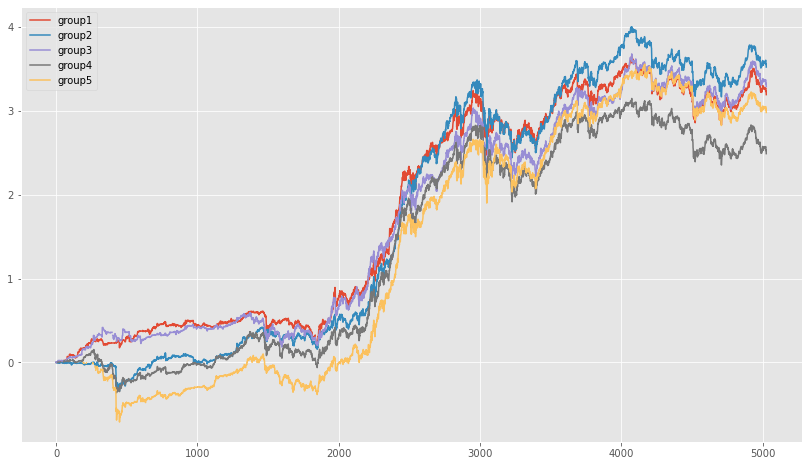

In [47]:
plt.plot(pd.Series(ret1_list).cumsum(), label="group1")
plt.plot(pd.Series(ret2_list).cumsum(), label="group2")
plt.plot(pd.Series(ret3_list).cumsum(), label="group3")
plt.plot(pd.Series(ret4_list).cumsum(), label="group4")
plt.plot(pd.Series(ret5_list).cumsum(), label="group5")
plt.legend()

In [48]:
factor_rank = factor_processed_dropna.rank(axis=1)
factor_rank

,BTC_USDT,1INCH_USDT,AAVE_USDT,ADA_USDT,ALGO_USDT,ATOM_USDT,AVAX_USDT,AXS_USDT,BAL_USDT,BAT_USDT,...,UNI_USDT,VET_USDT,WAVES_USDT,XEM_USDT,XLM_USDT,XMR_USDT,XRP_USDT,XTZ_USDT,ZEC_USDT,ZIL_USDT
2020-08-16 12:00:00,47.0,29.0,29.0,6.5,53.5,53.5,29.0,29.0,29.0,53.5,...,29.0,6.5,45.0,29.0,6.5,6.5,6.5,53.5,6.5,6.5
2020-08-16 16:00:00,43.0,28.0,28.0,6.5,51.5,51.5,28.0,28.0,28.0,51.5,...,28.0,6.5,51.5,28.0,6.5,6.5,6.5,51.5,6.5,51.5
2020-08-16 20:00:00,12.0,28.0,28.0,5.5,53.0,53.0,28.0,28.0,28.0,53.0,...,28.0,5.5,53.0,28.0,11.0,5.5,5.5,53.0,5.5,53.0
2020-08-17 00:00:00,7.5,30.0,30.0,7.5,52.0,52.0,30.0,30.0,30.0,52.0,...,30.0,7.5,52.0,30.0,7.5,7.5,7.5,52.0,7.5,52.0
2020-08-17 04:00:00,50.5,27.0,27.0,6.0,50.5,50.5,27.0,27.0,27.0,50.5,...,27.0,6.0,50.5,27.0,6.0,6.0,50.5,50.5,6.0,50.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,44.0,3.0,48.0,14.0,4.0,32.0,34.0,19.0,55.0,27.0,...,38.0,21.0,45.0,24.0,6.0,53.0,25.0,29.0,49.0,26.0
2022-12-01 20:00:00,38.0,3.0,46.0,13.0,5.0,26.0,29.0,18.0,52.0,21.0,...,42.0,27.0,40.0,37.0,6.0,54.0,28.0,25.0,51.0,32.0
2022-12-02 00:00:00,39.0,3.0,46.0,13.0,5.0,30.0,24.0,21.0,48.0,22.0,...,44.0,26.0,40.0,33.0,6.0,55.0,29.0,28.0,49.0,36.0
2022-12-02 04:00:00,38.0,3.0,43.0,13.0,4.0,29.0,30.0,24.0,52.0,23.0,...,49.0,26.0,46.0,21.0,5.0,57.0,17.0,28.0,53.0,36.0


In [49]:
period=20
factor_rank.corrwith(factor_rank.shift(20), axis=1)

2020-08-16 12:00:00         NaN
2020-08-16 16:00:00         NaN
2020-08-16 20:00:00         NaN
2020-08-17 00:00:00         NaN
2020-08-17 04:00:00         NaN
                         ...   
2022-12-01 16:00:00    0.503397
2022-12-01 20:00:00    0.466452
2022-12-02 00:00:00    0.431560
2022-12-02 04:00:00    0.366511
2022-12-02 08:00:00    0.366511
Length: 5028, dtype: float64

## Factor Return (Alpha)

In [50]:
# 组合index
dire_signal_list = ["nr", "dbook", "range_pos", "price_osci", "ma_dif", "kdj_k", "kdj_j"]
range_signal_list = ["", "range", "std", "trend_index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"__"+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)

In [51]:
all_signal_list

array(['nr', 'dbook', 'range_pos', 'price_osci', 'ma_dif', 'kdj_k',
       'kdj_j', 'nr__range', 'dbook__range', 'range_pos__range',
       'price_osci__range', 'ma_dif__range', 'kdj_k__range',
       'kdj_j__range', 'nr__std', 'dbook__std', 'range_pos__std',
       'price_osci__std', 'ma_dif__std', 'kdj_k__std', 'kdj_j__std',
       'nr__trend_index', 'dbook__trend_index', 'range_pos__trend_index',
       'price_osci__trend_index', 'ma_dif__trend_index',
       'kdj_k__trend_index', 'kdj_j__trend_index'], dtype='<U32')

In [52]:
factor_list = all_signal_list.tolist()

In [53]:
factor_list

['nr',
 'dbook',
 'range_pos',
 'price_osci',
 'ma_dif',
 'kdj_k',
 'kdj_j',
 'nr__range',
 'dbook__range',
 'range_pos__range',
 'price_osci__range',
 'ma_dif__range',
 'kdj_k__range',
 'kdj_j__range',
 'nr__std',
 'dbook__std',
 'range_pos__std',
 'price_osci__std',
 'ma_dif__std',
 'kdj_k__std',
 'kdj_j__std',
 'nr__trend_index',
 'dbook__trend_index',
 'range_pos__trend_index',
 'price_osci__trend_index',
 'ma_dif__trend_index',
 'kdj_k__trend_index',
 'kdj_j__trend_index']

** 构建因子矩阵 **

### 正则化factor

In [54]:
factor_df['BTC_USDT']['nr']

datetime
2020-01-01 08:00:00         NaN
2020-01-01 12:00:00    0.000000
2020-01-01 16:00:00    1.000000
2020-01-01 20:00:00    0.843486
2020-01-02 00:00:00    0.057719
                         ...   
2022-12-01 16:00:00    0.149149
2022-12-01 20:00:00    0.137317
2022-12-02 00:00:00    0.146429
2022-12-02 04:00:00    0.109460
2022-12-02 08:00:00    0.129730
Freq: 4H, Name: nr, Length: 6397, dtype: float64

In [55]:
# for symbol in symbol_list:
#     print(symbol)
#     for factor in factor_list:
#         g = factor_df[symbol][factor].rolling(200)
#         factor_df[symbol][factor] = (factor_df[symbol][factor]-g.mean())/g.std()

In [56]:
factor_df['BTC_USDT']['nr']

datetime
2020-01-01 08:00:00         NaN
2020-01-01 12:00:00    0.000000
2020-01-01 16:00:00    1.000000
2020-01-01 20:00:00    0.843486
2020-01-02 00:00:00    0.057719
                         ...   
2022-12-01 16:00:00    0.149149
2022-12-01 20:00:00    0.137317
2022-12-02 00:00:00    0.146429
2022-12-02 04:00:00    0.109460
2022-12-02 08:00:00    0.129730
Freq: 4H, Name: nr, Length: 6397, dtype: float64

## 与课程代码一致

```
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
```

In [57]:
# ls_factor_returns = pd.DataFrame()
factor_processed = {}

for factor in factor_list:
    print("factor", factor)
    cur_factor_df=pd.DataFrame()

    # 提取出当前因子下，所有symbol的因子值，放到cur_factor_df里
    for symbol in symbol_list:
#         cur_factor_df[symbol] = factor_df[symbol][factor]
        cur_factor_df[symbol] = factor_df[symbol][factor].rolling(len_dates).mean()
    
    # preprocess会按行，即对每日的数据(包含所有股票)进行归一化。
    # 
    factor_processed[factor] = standardize(winsorize(cur_factor_df).rank(axis=1,method="first")) 
#     # 对每一个因子，进行归一化（即对每一时刻截面的数据，按照因子值归一化），然后按每一时刻(按行)求和。
#     ls_factor_returns[factor] = factor_processed[factor].sum(axis=1)

factor nr
factor dbook
factor range_pos
factor price_osci
factor ma_dif
factor kdj_k
factor kdj_j
factor nr__range
factor dbook__range
factor range_pos__range
factor price_osci__range
factor ma_dif__range
factor kdj_k__range
factor kdj_j__range
factor nr__std
factor dbook__std
factor range_pos__std
factor price_osci__std
factor ma_dif__std
factor kdj_k__std
factor kdj_j__std
factor nr__trend_index
factor dbook__trend_index
factor range_pos__trend_index
factor price_osci__trend_index
factor ma_dif__trend_index
factor kdj_k__trend_index
factor kdj_j__trend_index


In [58]:
# 替换 factor_df 的因子值 为 factor_processed 下norm后的值。
# factor_processed以factor为key，
# 而 factor_df 以 symbol为key.
for factor in factor_list:
    print(factor)
    # 提取出当前因子下，所有symbol的因子值，放到cur_factor_df的dataframe里
    for symbol in symbol_list:
        factor_df[symbol][factor] = factor_processed[factor][symbol]

nr
dbook
range_pos
price_osci
ma_dif
kdj_k
kdj_j
nr__range
dbook__range
range_pos__range
price_osci__range
ma_dif__range
kdj_k__range
kdj_j__range
nr__std
dbook__std
range_pos__std
price_osci__std
ma_dif__std
kdj_k__std
kdj_j__std
nr__trend_index
dbook__trend_index
range_pos__trend_index
price_osci__trend_index
ma_dif__trend_index
kdj_k__trend_index
kdj_j__trend_index


In [59]:
# 合并所有数据。并设置2级索引 'datetime','symbol'
    

# 添加Symbol列
for symbol in symbol_list:
    print(symbol)
    factor_df[symbol]['symbol'] = symbol
    
# factor_df_multi=factor_df[symbol_list[0]].reset_index().set_index(['datetime','symbol'])
# 使用norm后的数据。
factor_df_multi=factor_df[symbol_list[0]].reset_index().set_index(['datetime','symbol'])

for symbol in symbol_list[1:]:
    print(symbol)
    factor_df_multi = pd.concat([factor_df_multi, factor_df[symbol].reset_index().set_index(['datetime','symbol'])])


BTC_USDT
1INCH_USDT
AAVE_USDT
ADA_USDT
ALGO_USDT
ATOM_USDT
AVAX_USDT
AXS_USDT
BAL_USDT
BAT_USDT
BCH_USDT
BNB_USDT
CHZ_USDT
COMP_USDT
CRV_USDT
DASH_USDT
DOGE_USDT
DOT_USDT
EGLD_USDT
ENJ_USDT
EOS_USDT
ETC_USDT
ETH_USDT
FIL_USDT
FTM_USDT
GRT_USDT
HBAR_USDT
HNT_USDT
HOT_USDT
IOTA_USDT
KAVA_USDT
KSM_USDT
LINK_USDT
LRC_USDT
LTC_USDT
MANA_USDT
MATIC_USDT
MKR_USDT
NEAR_USDT
NEO_USDT
QTUM_USDT
RUNE_USDT
RVN_USDT
SAND_USDT
SNX_USDT
SOL_USDT
SUSHI_USDT
THETA_USDT
TRX_USDT
UNI_USDT
VET_USDT
WAVES_USDT
XEM_USDT
XLM_USDT
XMR_USDT
XRP_USDT
XTZ_USDT
ZEC_USDT
ZIL_USDT
1INCH_USDT
AAVE_USDT
ADA_USDT
ALGO_USDT
ATOM_USDT
AVAX_USDT
AXS_USDT
BAL_USDT
BAT_USDT
BCH_USDT
BNB_USDT
CHZ_USDT
COMP_USDT
CRV_USDT
DASH_USDT
DOGE_USDT
DOT_USDT
EGLD_USDT
ENJ_USDT
EOS_USDT
ETC_USDT
ETH_USDT
FIL_USDT
FTM_USDT
GRT_USDT
HBAR_USDT
HNT_USDT
HOT_USDT
IOTA_USDT
KAVA_USDT
KSM_USDT
LINK_USDT
LRC_USDT
LTC_USDT
MANA_USDT
MATIC_USDT
MKR_USDT
NEAR_USDT
NEO_USDT
QTUM_USDT
RUNE_USDT
RVN_USDT
SAND_USDT
SNX_USDT
SOL_USDT
SUSHI_USDT
THETA

In [60]:
'''
移植自 https://github.com/quantopian/alphalens/blob/master/alphalens/performance.py
to_weights()
group, _demeaned=True, _equal_weight=False
等同于减去均值，除以每个数的绝对值的和。得到的权重包含正负号，保证负号(空仓)
        group = group - group.mean()
return group / group.abs().sum()

'''
    
def factor_weights(factor_data,
                   demeaned=True,
                   group_adjust=False,
                   equal_weight=False):
    """
    Computes asset weights by factor values and dividing by the sum of their
    absolute value (achieving gross leverage of 1). Positive factor values will
    results in positive weights and negative values in negative weights.
    Parameters
    ----------
    factor_data : pd.DataFrame - MultiIndex
        A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
        containing the values for a single alpha factor, forward returns for
        each period, the factor quantile/bin that factor value belongs to, and
        (optionally) the group the asset belongs to.
        - See full explanation in utils.get_clean_factor_and_forward_returns
    demeaned : bool
        Should this computation happen on a long short portfolio? if True,
        weights are computed by demeaning factor values and dividing by the sum
        of their absolute value (achieving gross leverage of 1). The sum of
        positive weights will be the same as the negative weights (absolute
        value), suitable for a dollar neutral long-short portfolio
    group_adjust : bool
        Should this computation happen on a group neutral portfolio? If True,
        compute group neutral weights: each group will weight the same and
        if 'demeaned' is enabled the factor values demeaning will occur on the
        group level.
    equal_weight : bool, optional
        if True the assets will be equal-weighted instead of factor-weighted
        If demeaned is True then the factor universe will be split in two
        equal sized groups, top assets with positive weights and bottom assets
        with negative weights
    Returns
    -------
    returns : pd.Series
        Assets weighted by factor value.
    """

    def to_weights(group, _demeaned, _equal_weight):
#         print("params", group, _demeaned, _equal_weight)

        if _equal_weight:
            group = group.copy()

            if _demeaned:
                # top assets positive weights, bottom ones negative
                group = group - group.median()

            negative_mask = group < 0
            group[negative_mask] = -1.0
            positive_mask = group > 0
            group[positive_mask] = 1.0

            if _demeaned:
                # positive weights must equal negative weights
                if negative_mask.any():
                    group[negative_mask] /= negative_mask.sum()
                if positive_mask.any():
                    group[positive_mask] /= positive_mask.sum()

        elif _demeaned:
            group = group - group.mean()

        return group / group.abs().sum()

    grouper = [factor_data.index.get_level_values('datetime')]
    if group_adjust:
        grouper.append('group')

#     weights = factor_data.groupby(grouper)['factor'] \
    weights = factor_data.groupby(grouper) \
        .apply(to_weights, demeaned, equal_weight)

    if group_adjust:
        weights = weights.groupby(level='datetime').apply(to_weights, False, False)

    return weights


# 注意 next_ret 是forward return,
def factor_returns(factor_data, next_ret,
                   demeaned=True,
                   group_adjust=False,
                   equal_weight=False,
                   by_asset=False):
    """
    Computes period wise returns for portfolio weighted by factor
    values.
    Parameters
    ----------
    factor_data : pd.DataFrame - MultiIndex
        A MultiIndex DataFrame indexed by date (level 0) and asset (level 1),
        containing the values for a single alpha factor, forward returns for
        each period, the factor quantile/bin that factor value belongs to, and
        (optionally) the group the asset belongs to.
        - See full explanation in utils.get_clean_factor_and_forward_returns
    demeaned : bool
        Control how to build factor weights
        -- see performance.factor_weights for a full explanation
    group_adjust : bool
        Control how to build factor weights
        -- see performance.factor_weights for a full explanation
    equal_weight : bool, optional
        Control how to build factor weights
        -- see performance.factor_weights for a full explanation
    by_asset: bool, optional
        If True, returns are reported separately for each esset.
    Returns
    -------
    returns : pd.DataFrame
        Period wise factor returns
    """

    weights = \
        factor_weights(factor_data, demeaned, group_adjust, equal_weight)

#     weighted_returns = \
#         factor_data[utils.get_forward_returns_columns(factor_data.columns)] \
    weighted_returns = \
        next_ret \
        .multiply(weights, axis=0)

    if by_asset:
        returns = weighted_returns
    else:
        returns = weighted_returns.groupby(level='datetime').sum()

    return returns

In [61]:
ls_factor_returns = pd.DataFrame()

# 把tmr_ret的dataframe()转换为多个索引的series,
# tmr_ret 是以datetime为index，symbol为列名
# 转换为 [datetime,symbol] 的multiindex的series。
tmr_ret_series = tmr_ret.unstack()
tmr_ret_series.index.names=['symbol','datetime']
tmr_ret_series = tmr_ret_series.swaplevel()

for factor, factor_data in factor_df_multi.items():
    if factor in factor_list:
#     if factor == 'kdj_j-trend_index':
        print(factor)
#         print(factor_data)
        ls_factor_returns[factor] = factor_returns(factor_data, tmr_ret_series)

# (1+ls_factor_returns).cumprod().plot()

nr
dbook
range_pos
price_osci
ma_dif
kdj_k
kdj_j
nr__range
dbook__range
range_pos__range
price_osci__range
ma_dif__range
kdj_k__range
kdj_j__range
nr__std
dbook__std
range_pos__std
price_osci__std
ma_dif__std
kdj_k__std
kdj_j__std
nr__trend_index
dbook__trend_index
range_pos__trend_index
price_osci__trend_index
ma_dif__trend_index
kdj_k__trend_index
kdj_j__trend_index


<AxesSubplot:xlabel='datetime'>

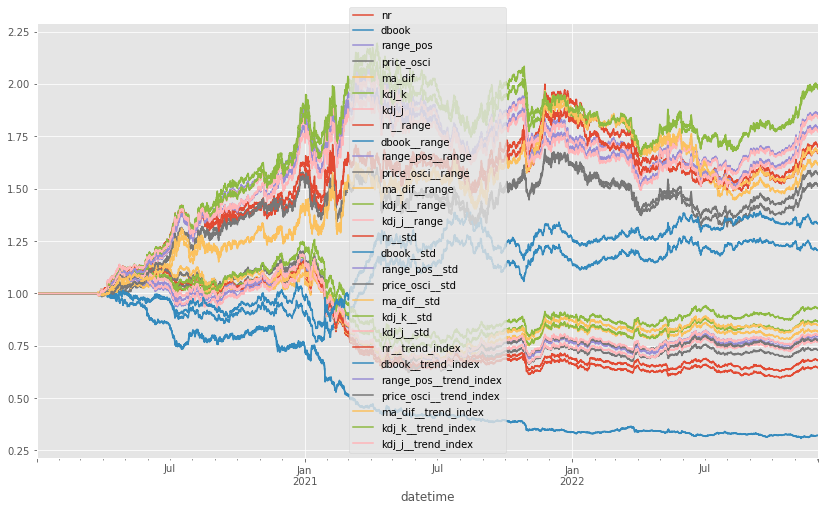

In [62]:
(1+ls_factor_returns).cumprod().plot()

In [63]:
# def func_to_weights(group, _demeaned, _equal_weight):
# #         print("params", group, _demeaned, _equal_weight)

#     if _equal_weight:
#         group = group.copy()

#         if _demeaned:
#             # top assets positive weights, bottom ones negative
#             group = group - group.median()

#         negative_mask = group < 0
#         group[negative_mask] = -1.0
#         positive_mask = group > 0
#         group[positive_mask] = 1.0

#         if _demeaned:
#             # positive weights must equal negative weights
#             if negative_mask.any():
#                 group[negative_mask] /= negative_mask.sum()
#             if positive_mask.any():
#                 group[positive_mask] /= positive_mask.sum()

#     elif _demeaned:
#         group = group - group.mean()

#     return group / group.abs().sum()

In [64]:
# func_to_weights(factor_data['2022-09-16 20:00:00'], True, False)

### Sharpe Ratio of each factor

In [65]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    sharpe_ratio = annualization_factor * factor_returns.mean() / factor_returns.std()
    
    return sharpe_ratio

In [66]:
ls_factor_returns

,nr,dbook,range_pos,price_osci,ma_dif,kdj_k,kdj_j,nr__range,dbook__range,range_pos__range,...,ma_dif__std,kdj_k__std,kdj_j__std,nr__trend_index,dbook__trend_index,range_pos__trend_index,price_osci__trend_index,ma_dif__trend_index,kdj_k__trend_index,kdj_j__trend_index
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 16:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-01 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01 16:00:00,-0.000287,-0.000120,-0.000050,-0.000078,-0.000746,-0.000102,-0.000079,-0.000899,0.000998,-0.000405,...,-0.001520,-0.000766,-0.000586,-0.000307,-0.000386,-0.000094,-0.000196,-0.000976,0.000026,-0.000076
2022-12-01 20:00:00,-0.003287,-0.000271,-0.002997,-0.002658,-0.003048,-0.002942,-0.002951,-0.004531,0.001857,-0.004364,...,-0.003517,-0.004235,-0.004517,-0.003311,-0.000924,-0.003271,-0.002686,-0.003218,-0.003141,-0.003253
2022-12-02 00:00:00,-0.002486,0.000851,-0.002703,-0.002884,-0.002351,-0.002639,-0.002718,0.001380,-0.001614,0.000959,...,0.001622,0.000802,0.000875,-0.002225,0.001169,-0.002446,-0.002537,-0.002030,-0.002539,-0.002486


In [67]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

nr                         0.38
dbook                      0.15
range_pos                  0.44
price_osci                 0.31
ma_dif                     0.32
kdj_k                      0.49
kdj_j                      0.44
nr__range                 -0.29
dbook__range              -0.74
range_pos__range          -0.15
price_osci__range         -0.20
ma_dif__range             -0.11
kdj_k__range              -0.08
kdj_j__range              -0.16
nr__std                   -0.25
dbook__std                -0.74
range_pos__std            -0.14
price_osci__std           -0.15
ma_dif__std               -0.09
kdj_k__std                -0.03
kdj_j__std                -0.13
nr__trend_index            0.37
dbook__trend_index         0.22
range_pos__trend_index     0.42
price_osci__trend_index    0.33
ma_dif__trend_index        0.35
kdj_k__trend_index         0.49
kdj_j__trend_index         0.42
dtype: float64

In [68]:
sharpe_series = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

In [69]:
sharpe_series.sort_values()

dbook__std                -0.74
dbook__range              -0.74
nr__range                 -0.29
nr__std                   -0.25
price_osci__range         -0.20
kdj_j__range              -0.16
range_pos__range          -0.15
price_osci__std           -0.15
range_pos__std            -0.14
kdj_j__std                -0.13
ma_dif__range             -0.11
ma_dif__std               -0.09
kdj_k__range              -0.08
kdj_k__std                -0.03
dbook                      0.15
dbook__trend_index         0.22
price_osci                 0.31
ma_dif                     0.32
price_osci__trend_index    0.33
ma_dif__trend_index        0.35
nr__trend_index            0.37
nr                         0.38
range_pos__trend_index     0.42
kdj_j__trend_index         0.42
kdj_j                      0.44
range_pos                  0.44
kdj_k                      0.49
kdj_k__trend_index         0.49
dtype: float64

In [70]:
sharpe_series[sharpe_series>0].index

Index(['nr', 'dbook', 'range_pos', 'price_osci', 'ma_dif', 'kdj_k', 'kdj_j',
       'nr__trend_index', 'dbook__trend_index', 'range_pos__trend_index',
       'price_osci__trend_index', 'ma_dif__trend_index', 'kdj_k__trend_index',
       'kdj_j__trend_index'],
      dtype='object')

### Combined Alpha Vector
To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

**注意alpha因子要先norm，统一量纲。每个因子的均值为0 方差为1**

In [71]:
factor_df_multi['alpha_vector'] = factor_df_multi[factor_list].mean(axis=1)

# alphas = factor_df_multi[['alpha_vector']]
# # 注意，这里提取的是数据中最后一天的alpha。
# alpha_vector = alphas.loc[factor_df_multi.index.get_level_values(0)[-1]]
# alpha_vector.head()

In [72]:
factor_df_multi.index.get_level_values(0)[-1]

Timestamp('2022-12-02 08:00:00')

## 先选取所有alpha 因子，做ols，看各因子权重

## Factor Exposures and Factor Returns

Recall that:

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. Since we get the factor exposures from the Barra data, and we know the returns, it is possible to estimate the factor returns. In this notebook, we will use the Ordinary Least Squares (OLS) method to estimate the factor exposures, $f_{j,t}$, by using $\beta_{i,j,t-2}$ as the independent variable, and $r_{i,t}$ as the dependent variable.

** estimate_factor_returns() 为根据因子值，做线性回归，factor return 为回归后的因子权重。**
** 因子的权重越大，factor return越大。**

** 注意，$r_{i,t}$的下表为t，为未来的return **

** 而$\beta_{i,j,t-2}$的下表为t-2，为当前时刻计算出来的因子 **

** `TODO` 要加上risk model(`PCA`)的因子factor_beta(`components`)，来进行回归 **

In [73]:
import patsy
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler

In [74]:
def wins(x,a,b):
    return np.where(x <= a, a, np.where(x >= b, b, x))

In [75]:
def get_default():
    all_factors = factors_from_names(list(df))
    default_res = {}
    for factor in all_factors:
        # 赋予较小的数
        default_res[factor]=-1e-10
    return default_res
        

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
#     return list(filter(lambda x: "USFASTD_" in x, n))
    return factor_list

def estimate_factor_returns(df): 
    #  数据中包含nan，返回0
    if df.isna().values.any():
        def_res = get_default()
        return pd.Series({'params':def_res})
    
    ## build universe based on filters 
#     estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    estu = df.copy(deep=True)
  
    ## winsorize returns for fitting 
    # return 上下幅度最大变动为25%
    estu['next_returns'] = wins(estu['next_returns'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "next_returns")
    
    # TODO: factors 中包含pca的因子
    # 参照： http://localhost:8888/notebooks/work/personal/tmp-main/m8/m8/performance_attribution/performance_attribution_solution.ipynb
    model = ols(form, data=estu)
    results = model.fit()
    return results


def estimate_factor_returns_pca(df, pca_risk_model): 
    #  数据中包含nan，返回0
    if df.isna().values.any():
        def_res = get_default()
        return pd.Series({'params':def_res})
    
    ## build universe based on filters 
#     estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    estu = df.copy(deep=True)
  
    ## winsorize returns for fitting 
    # return 上下幅度最大变动为25%
    estu['next_returns'] = wins(estu['next_returns'], -0.25, 0.25)

#     all_factors = factors_from_names(list(df))
    alpha_factors = factor_list
    
    # 合并risk_model的factor，和 alpha因子
    risk_model.factor_betas_.index.names=['symbol'] # 命名所有名字为symbol
    estu = estu.merge(risk_model.factor_betas_, how="left", on='symbol')
    
    # risk factors(pca factor_beta) + alpha factors
    # 包含factor_betas来标准化
    all_factors = risk_model.factor_betas_.columns.tolist() + alpha_factors
#     all_factors = alpha_factors

    # 注意，这里使用"next_returns",注意数据范围，避免使用未来数据。
    form = get_formula(all_factors, "next_returns")
    
    # 标准化矩阵。
#     scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
#     scaler = StandardScaler(copy=True)
#     scaler.fit(estu[all_factors])
#     estu_norm = pd.DataFrame(scaler.transform(estu[all_factors]), index=estu.index, columns=all_factors)
#     estu_norm['next_returns'] = estu['next_returns']
    
    
    # TODO: factors 中包含pca的因子
    # 参照： http://localhost:8888/notebooks/work/personal/tmp-main/m8/m8/performance_attribution/performance_attribution_solution.ipynb
    model = ols(form, data=estu)
#     model = ols(form, data=estu_norm)

    results = model.fit()
#     print(estu_norm)
    return results

In [76]:
# 提取所有dates (factor_df_multi 的一级索引)，用set去重，然后sort排序。
date_list = list(set(factor_df_multi.index.get_level_values(0)))
date_list.sort()

In [77]:
facret = {}

# 通过OLS，计算因子回报 factor return
# 因为回测后，计算contribution需要用到facret。为了统一date。使用当前时间，而非前一时刻
for idx,date in enumerate(date_list):
    if date < start_time:
        continue
    print(idx, date, "->", date_list[idx-1])
    
#     facret[date] = estimate_factor_returns(factor_df_multi.loc[date]).params

    # 包含pca模型
    risk_model = RiskModelPCA(num_factor_exposures)
    # pca模型使用直到当前date的所有close数据，
    # 去掉最后一行的额数据，因为最后一行是用来预测的。
#     risk_model.fit(total_close_df.loc[:date_list[idx-1]])
    risk_model.fit(total_close_df.loc[:date_list[idx]])
    
    # alpha factor的dataframe，去掉最后一行，使用倒数第2行，避免使用未来数据。
    # 因为要用next_return作为回归的y，如果使用最后一行的"next_returns",会超出当前的数据范围。
    # 同时需要保证，pca risk model使用的数据，也要去掉最后一行。
#     facret[date] = estimate_factor_returns_pca(factor_df_multi.loc[date_list[idx-1]], risk_model).params
    facret[date] = estimate_factor_returns_pca(factor_df_multi.loc[date_list[idx]], risk_model).params
    
#     print(facret[date])
#     break

2194 2021-01-01 00:00:00 -> 2020-12-31 20:00:00
2195 2021-01-01 04:00:00 -> 2021-01-01 00:00:00
2196 2021-01-01 08:00:00 -> 2021-01-01 04:00:00
2197 2021-01-01 12:00:00 -> 2021-01-01 08:00:00
2198 2021-01-01 16:00:00 -> 2021-01-01 12:00:00
2199 2021-01-01 20:00:00 -> 2021-01-01 16:00:00
2200 2021-01-02 00:00:00 -> 2021-01-01 20:00:00
2201 2021-01-02 04:00:00 -> 2021-01-02 00:00:00
2202 2021-01-02 08:00:00 -> 2021-01-02 04:00:00
2203 2021-01-02 12:00:00 -> 2021-01-02 08:00:00
2204 2021-01-02 16:00:00 -> 2021-01-02 12:00:00
2205 2021-01-02 20:00:00 -> 2021-01-02 16:00:00
2206 2021-01-03 00:00:00 -> 2021-01-02 20:00:00
2207 2021-01-03 04:00:00 -> 2021-01-03 00:00:00
2208 2021-01-03 08:00:00 -> 2021-01-03 04:00:00
2209 2021-01-03 12:00:00 -> 2021-01-03 08:00:00
2210 2021-01-03 16:00:00 -> 2021-01-03 12:00:00
2211 2021-01-03 20:00:00 -> 2021-01-03 16:00:00
2212 2021-01-04 00:00:00 -> 2021-01-03 20:00:00
2213 2021-01-04 04:00:00 -> 2021-01-04 00:00:00
2214 2021-01-04 08:00:00 -> 2021-01-04 0

2367 2021-01-29 20:00:00 -> 2021-01-29 16:00:00
2368 2021-01-30 00:00:00 -> 2021-01-29 20:00:00
2369 2021-01-30 04:00:00 -> 2021-01-30 00:00:00
2370 2021-01-30 08:00:00 -> 2021-01-30 04:00:00
2371 2021-01-30 12:00:00 -> 2021-01-30 08:00:00
2372 2021-01-30 16:00:00 -> 2021-01-30 12:00:00
2373 2021-01-30 20:00:00 -> 2021-01-30 16:00:00
2374 2021-01-31 00:00:00 -> 2021-01-30 20:00:00
2375 2021-01-31 04:00:00 -> 2021-01-31 00:00:00
2376 2021-01-31 08:00:00 -> 2021-01-31 04:00:00
2377 2021-01-31 12:00:00 -> 2021-01-31 08:00:00
2378 2021-01-31 16:00:00 -> 2021-01-31 12:00:00
2379 2021-01-31 20:00:00 -> 2021-01-31 16:00:00
2380 2021-02-01 00:00:00 -> 2021-01-31 20:00:00
2381 2021-02-01 04:00:00 -> 2021-02-01 00:00:00
2382 2021-02-01 08:00:00 -> 2021-02-01 04:00:00
2383 2021-02-01 12:00:00 -> 2021-02-01 08:00:00
2384 2021-02-01 16:00:00 -> 2021-02-01 12:00:00
2385 2021-02-01 20:00:00 -> 2021-02-01 16:00:00
2386 2021-02-02 00:00:00 -> 2021-02-01 20:00:00
2387 2021-02-02 04:00:00 -> 2021-02-02 0

2559 2021-03-02 20:00:00 -> 2021-03-02 16:00:00
2560 2021-03-03 00:00:00 -> 2021-03-02 20:00:00
2561 2021-03-03 04:00:00 -> 2021-03-03 00:00:00
2562 2021-03-03 08:00:00 -> 2021-03-03 04:00:00
2563 2021-03-03 12:00:00 -> 2021-03-03 08:00:00
2564 2021-03-03 16:00:00 -> 2021-03-03 12:00:00
2565 2021-03-03 20:00:00 -> 2021-03-03 16:00:00
2566 2021-03-04 00:00:00 -> 2021-03-03 20:00:00
2567 2021-03-04 04:00:00 -> 2021-03-04 00:00:00
2568 2021-03-04 08:00:00 -> 2021-03-04 04:00:00
2569 2021-03-04 12:00:00 -> 2021-03-04 08:00:00
2570 2021-03-04 16:00:00 -> 2021-03-04 12:00:00
2571 2021-03-04 20:00:00 -> 2021-03-04 16:00:00
2572 2021-03-05 00:00:00 -> 2021-03-04 20:00:00
2573 2021-03-05 04:00:00 -> 2021-03-05 00:00:00
2574 2021-03-05 08:00:00 -> 2021-03-05 04:00:00
2575 2021-03-05 12:00:00 -> 2021-03-05 08:00:00
2576 2021-03-05 16:00:00 -> 2021-03-05 12:00:00
2577 2021-03-05 20:00:00 -> 2021-03-05 16:00:00
2578 2021-03-06 00:00:00 -> 2021-03-05 20:00:00
2579 2021-03-06 04:00:00 -> 2021-03-06 0

2753 2021-04-04 04:00:00 -> 2021-04-04 00:00:00
2754 2021-04-04 08:00:00 -> 2021-04-04 04:00:00
2755 2021-04-04 12:00:00 -> 2021-04-04 08:00:00
2756 2021-04-04 16:00:00 -> 2021-04-04 12:00:00
2757 2021-04-04 20:00:00 -> 2021-04-04 16:00:00
2758 2021-04-05 00:00:00 -> 2021-04-04 20:00:00
2759 2021-04-05 04:00:00 -> 2021-04-05 00:00:00
2760 2021-04-05 08:00:00 -> 2021-04-05 04:00:00
2761 2021-04-05 12:00:00 -> 2021-04-05 08:00:00
2762 2021-04-05 16:00:00 -> 2021-04-05 12:00:00
2763 2021-04-05 20:00:00 -> 2021-04-05 16:00:00
2764 2021-04-06 00:00:00 -> 2021-04-05 20:00:00
2765 2021-04-06 04:00:00 -> 2021-04-06 00:00:00
2766 2021-04-06 08:00:00 -> 2021-04-06 04:00:00
2767 2021-04-06 12:00:00 -> 2021-04-06 08:00:00
2768 2021-04-06 16:00:00 -> 2021-04-06 12:00:00
2769 2021-04-06 20:00:00 -> 2021-04-06 16:00:00
2770 2021-04-07 00:00:00 -> 2021-04-06 20:00:00
2771 2021-04-07 04:00:00 -> 2021-04-07 00:00:00
2772 2021-04-07 08:00:00 -> 2021-04-07 04:00:00
2773 2021-04-07 12:00:00 -> 2021-04-07 0

2935 2021-05-04 12:00:00 -> 2021-05-04 08:00:00
2936 2021-05-04 16:00:00 -> 2021-05-04 12:00:00
2937 2021-05-04 20:00:00 -> 2021-05-04 16:00:00
2938 2021-05-05 00:00:00 -> 2021-05-04 20:00:00
2939 2021-05-05 04:00:00 -> 2021-05-05 00:00:00
2940 2021-05-05 08:00:00 -> 2021-05-05 04:00:00
2941 2021-05-05 12:00:00 -> 2021-05-05 08:00:00
2942 2021-05-05 16:00:00 -> 2021-05-05 12:00:00
2943 2021-05-05 20:00:00 -> 2021-05-05 16:00:00
2944 2021-05-06 00:00:00 -> 2021-05-05 20:00:00
2945 2021-05-06 04:00:00 -> 2021-05-06 00:00:00
2946 2021-05-06 08:00:00 -> 2021-05-06 04:00:00
2947 2021-05-06 12:00:00 -> 2021-05-06 08:00:00
2948 2021-05-06 16:00:00 -> 2021-05-06 12:00:00
2949 2021-05-06 20:00:00 -> 2021-05-06 16:00:00
2950 2021-05-07 00:00:00 -> 2021-05-06 20:00:00
2951 2021-05-07 04:00:00 -> 2021-05-07 00:00:00
2952 2021-05-07 08:00:00 -> 2021-05-07 04:00:00
2953 2021-05-07 12:00:00 -> 2021-05-07 08:00:00
2954 2021-05-07 16:00:00 -> 2021-05-07 12:00:00
2955 2021-05-07 20:00:00 -> 2021-05-07 1

3108 2021-06-02 08:00:00 -> 2021-06-02 04:00:00
3109 2021-06-02 12:00:00 -> 2021-06-02 08:00:00
3110 2021-06-02 16:00:00 -> 2021-06-02 12:00:00
3111 2021-06-02 20:00:00 -> 2021-06-02 16:00:00
3112 2021-06-03 00:00:00 -> 2021-06-02 20:00:00
3113 2021-06-03 04:00:00 -> 2021-06-03 00:00:00
3114 2021-06-03 08:00:00 -> 2021-06-03 04:00:00
3115 2021-06-03 12:00:00 -> 2021-06-03 08:00:00
3116 2021-06-03 16:00:00 -> 2021-06-03 12:00:00
3117 2021-06-03 20:00:00 -> 2021-06-03 16:00:00
3118 2021-06-04 00:00:00 -> 2021-06-03 20:00:00
3119 2021-06-04 04:00:00 -> 2021-06-04 00:00:00
3120 2021-06-04 08:00:00 -> 2021-06-04 04:00:00
3121 2021-06-04 12:00:00 -> 2021-06-04 08:00:00
3122 2021-06-04 16:00:00 -> 2021-06-04 12:00:00
3123 2021-06-04 20:00:00 -> 2021-06-04 16:00:00
3124 2021-06-05 00:00:00 -> 2021-06-04 20:00:00
3125 2021-06-05 04:00:00 -> 2021-06-05 00:00:00
3126 2021-06-05 08:00:00 -> 2021-06-05 04:00:00
3127 2021-06-05 12:00:00 -> 2021-06-05 08:00:00
3128 2021-06-05 16:00:00 -> 2021-06-05 1

3284 2021-07-01 16:00:00 -> 2021-07-01 12:00:00
3285 2021-07-01 20:00:00 -> 2021-07-01 16:00:00
3286 2021-07-02 00:00:00 -> 2021-07-01 20:00:00
3287 2021-07-02 04:00:00 -> 2021-07-02 00:00:00
3288 2021-07-02 08:00:00 -> 2021-07-02 04:00:00
3289 2021-07-02 12:00:00 -> 2021-07-02 08:00:00
3290 2021-07-02 16:00:00 -> 2021-07-02 12:00:00
3291 2021-07-02 20:00:00 -> 2021-07-02 16:00:00
3292 2021-07-03 00:00:00 -> 2021-07-02 20:00:00
3293 2021-07-03 04:00:00 -> 2021-07-03 00:00:00
3294 2021-07-03 08:00:00 -> 2021-07-03 04:00:00
3295 2021-07-03 12:00:00 -> 2021-07-03 08:00:00
3296 2021-07-03 16:00:00 -> 2021-07-03 12:00:00
3297 2021-07-03 20:00:00 -> 2021-07-03 16:00:00
3298 2021-07-04 00:00:00 -> 2021-07-03 20:00:00
3299 2021-07-04 04:00:00 -> 2021-07-04 00:00:00
3300 2021-07-04 08:00:00 -> 2021-07-04 04:00:00
3301 2021-07-04 12:00:00 -> 2021-07-04 08:00:00
3302 2021-07-04 16:00:00 -> 2021-07-04 12:00:00
3303 2021-07-04 20:00:00 -> 2021-07-04 16:00:00
3304 2021-07-05 00:00:00 -> 2021-07-04 2

3458 2021-07-30 16:00:00 -> 2021-07-30 12:00:00
3459 2021-07-30 20:00:00 -> 2021-07-30 16:00:00
3460 2021-07-31 00:00:00 -> 2021-07-30 20:00:00
3461 2021-07-31 04:00:00 -> 2021-07-31 00:00:00
3462 2021-07-31 08:00:00 -> 2021-07-31 04:00:00
3463 2021-07-31 12:00:00 -> 2021-07-31 08:00:00
3464 2021-07-31 16:00:00 -> 2021-07-31 12:00:00
3465 2021-07-31 20:00:00 -> 2021-07-31 16:00:00
3466 2021-08-01 00:00:00 -> 2021-07-31 20:00:00
3467 2021-08-01 04:00:00 -> 2021-08-01 00:00:00
3468 2021-08-01 08:00:00 -> 2021-08-01 04:00:00
3469 2021-08-01 12:00:00 -> 2021-08-01 08:00:00
3470 2021-08-01 16:00:00 -> 2021-08-01 12:00:00
3471 2021-08-01 20:00:00 -> 2021-08-01 16:00:00
3472 2021-08-02 00:00:00 -> 2021-08-01 20:00:00
3473 2021-08-02 04:00:00 -> 2021-08-02 00:00:00
3474 2021-08-02 08:00:00 -> 2021-08-02 04:00:00
3475 2021-08-02 12:00:00 -> 2021-08-02 08:00:00
3476 2021-08-02 16:00:00 -> 2021-08-02 12:00:00
3477 2021-08-02 20:00:00 -> 2021-08-02 16:00:00
3478 2021-08-03 00:00:00 -> 2021-08-02 2

3630 2021-08-28 08:00:00 -> 2021-08-28 04:00:00
3631 2021-08-28 12:00:00 -> 2021-08-28 08:00:00
3632 2021-08-28 16:00:00 -> 2021-08-28 12:00:00
3633 2021-08-28 20:00:00 -> 2021-08-28 16:00:00
3634 2021-08-29 00:00:00 -> 2021-08-28 20:00:00
3635 2021-08-29 04:00:00 -> 2021-08-29 00:00:00
3636 2021-08-29 08:00:00 -> 2021-08-29 04:00:00
3637 2021-08-29 12:00:00 -> 2021-08-29 08:00:00
3638 2021-08-29 16:00:00 -> 2021-08-29 12:00:00
3639 2021-08-29 20:00:00 -> 2021-08-29 16:00:00
3640 2021-08-30 00:00:00 -> 2021-08-29 20:00:00
3641 2021-08-30 04:00:00 -> 2021-08-30 00:00:00
3642 2021-08-30 08:00:00 -> 2021-08-30 04:00:00
3643 2021-08-30 12:00:00 -> 2021-08-30 08:00:00
3644 2021-08-30 16:00:00 -> 2021-08-30 12:00:00
3645 2021-08-30 20:00:00 -> 2021-08-30 16:00:00
3646 2021-08-31 00:00:00 -> 2021-08-30 20:00:00
3647 2021-08-31 04:00:00 -> 2021-08-31 00:00:00
3648 2021-08-31 08:00:00 -> 2021-08-31 04:00:00
3649 2021-08-31 12:00:00 -> 2021-08-31 08:00:00
3650 2021-08-31 16:00:00 -> 2021-08-31 1

3803 2021-09-26 04:00:00 -> 2021-09-26 00:00:00
3804 2021-09-26 08:00:00 -> 2021-09-26 04:00:00
3805 2021-09-26 12:00:00 -> 2021-09-26 08:00:00
3806 2021-09-26 16:00:00 -> 2021-09-26 12:00:00
3807 2021-09-26 20:00:00 -> 2021-09-26 16:00:00
3808 2021-09-27 00:00:00 -> 2021-09-26 20:00:00
3809 2021-09-27 04:00:00 -> 2021-09-27 00:00:00
3810 2021-09-27 08:00:00 -> 2021-09-27 04:00:00
3811 2021-09-27 12:00:00 -> 2021-09-27 08:00:00
3812 2021-09-27 16:00:00 -> 2021-09-27 12:00:00
3813 2021-09-27 20:00:00 -> 2021-09-27 16:00:00
3814 2021-09-28 00:00:00 -> 2021-09-27 20:00:00
3815 2021-09-28 04:00:00 -> 2021-09-28 00:00:00
3816 2021-09-28 08:00:00 -> 2021-09-28 04:00:00
3817 2021-09-28 12:00:00 -> 2021-09-28 08:00:00
3818 2021-09-28 16:00:00 -> 2021-09-28 12:00:00
3819 2021-09-28 20:00:00 -> 2021-09-28 16:00:00
3820 2021-09-29 00:00:00 -> 2021-09-28 20:00:00
3821 2021-09-29 04:00:00 -> 2021-09-29 00:00:00
3822 2021-09-29 08:00:00 -> 2021-09-29 04:00:00
3823 2021-09-29 12:00:00 -> 2021-09-29 0

3976 2021-10-25 00:00:00 -> 2021-10-24 20:00:00
3977 2021-10-25 04:00:00 -> 2021-10-25 00:00:00
3978 2021-10-25 08:00:00 -> 2021-10-25 04:00:00
3979 2021-10-25 12:00:00 -> 2021-10-25 08:00:00
3980 2021-10-25 16:00:00 -> 2021-10-25 12:00:00
3981 2021-10-25 20:00:00 -> 2021-10-25 16:00:00
3982 2021-10-26 00:00:00 -> 2021-10-25 20:00:00
3983 2021-10-26 04:00:00 -> 2021-10-26 00:00:00
3984 2021-10-26 08:00:00 -> 2021-10-26 04:00:00
3985 2021-10-26 12:00:00 -> 2021-10-26 08:00:00
3986 2021-10-26 16:00:00 -> 2021-10-26 12:00:00
3987 2021-10-26 20:00:00 -> 2021-10-26 16:00:00
3988 2021-10-27 00:00:00 -> 2021-10-26 20:00:00
3989 2021-10-27 04:00:00 -> 2021-10-27 00:00:00
3990 2021-10-27 08:00:00 -> 2021-10-27 04:00:00
3991 2021-10-27 12:00:00 -> 2021-10-27 08:00:00
3992 2021-10-27 16:00:00 -> 2021-10-27 12:00:00
3993 2021-10-27 20:00:00 -> 2021-10-27 16:00:00
3994 2021-10-28 00:00:00 -> 2021-10-27 20:00:00
3995 2021-10-28 04:00:00 -> 2021-10-28 00:00:00
3996 2021-10-28 08:00:00 -> 2021-10-28 0

4151 2021-11-23 04:00:00 -> 2021-11-23 00:00:00
4152 2021-11-23 08:00:00 -> 2021-11-23 04:00:00
4153 2021-11-23 12:00:00 -> 2021-11-23 08:00:00
4154 2021-11-23 16:00:00 -> 2021-11-23 12:00:00
4155 2021-11-23 20:00:00 -> 2021-11-23 16:00:00
4156 2021-11-24 00:00:00 -> 2021-11-23 20:00:00
4157 2021-11-24 04:00:00 -> 2021-11-24 00:00:00
4158 2021-11-24 08:00:00 -> 2021-11-24 04:00:00
4159 2021-11-24 12:00:00 -> 2021-11-24 08:00:00
4160 2021-11-24 16:00:00 -> 2021-11-24 12:00:00
4161 2021-11-24 20:00:00 -> 2021-11-24 16:00:00
4162 2021-11-25 00:00:00 -> 2021-11-24 20:00:00
4163 2021-11-25 04:00:00 -> 2021-11-25 00:00:00
4164 2021-11-25 08:00:00 -> 2021-11-25 04:00:00
4165 2021-11-25 12:00:00 -> 2021-11-25 08:00:00
4166 2021-11-25 16:00:00 -> 2021-11-25 12:00:00
4167 2021-11-25 20:00:00 -> 2021-11-25 16:00:00
4168 2021-11-26 00:00:00 -> 2021-11-25 20:00:00
4169 2021-11-26 04:00:00 -> 2021-11-26 00:00:00
4170 2021-11-26 08:00:00 -> 2021-11-26 04:00:00
4171 2021-11-26 12:00:00 -> 2021-11-26 0

4326 2021-12-22 08:00:00 -> 2021-12-22 04:00:00
4327 2021-12-22 12:00:00 -> 2021-12-22 08:00:00
4328 2021-12-22 16:00:00 -> 2021-12-22 12:00:00
4329 2021-12-22 20:00:00 -> 2021-12-22 16:00:00
4330 2021-12-23 00:00:00 -> 2021-12-22 20:00:00
4331 2021-12-23 04:00:00 -> 2021-12-23 00:00:00
4332 2021-12-23 08:00:00 -> 2021-12-23 04:00:00
4333 2021-12-23 12:00:00 -> 2021-12-23 08:00:00
4334 2021-12-23 16:00:00 -> 2021-12-23 12:00:00
4335 2021-12-23 20:00:00 -> 2021-12-23 16:00:00
4336 2021-12-24 00:00:00 -> 2021-12-23 20:00:00
4337 2021-12-24 04:00:00 -> 2021-12-24 00:00:00
4338 2021-12-24 08:00:00 -> 2021-12-24 04:00:00
4339 2021-12-24 12:00:00 -> 2021-12-24 08:00:00
4340 2021-12-24 16:00:00 -> 2021-12-24 12:00:00
4341 2021-12-24 20:00:00 -> 2021-12-24 16:00:00
4342 2021-12-25 00:00:00 -> 2021-12-24 20:00:00
4343 2021-12-25 04:00:00 -> 2021-12-25 00:00:00
4344 2021-12-25 08:00:00 -> 2021-12-25 04:00:00
4345 2021-12-25 12:00:00 -> 2021-12-25 08:00:00
4346 2021-12-25 16:00:00 -> 2021-12-25 1

4500 2022-01-20 08:00:00 -> 2022-01-20 04:00:00
4501 2022-01-20 12:00:00 -> 2022-01-20 08:00:00
4502 2022-01-20 16:00:00 -> 2022-01-20 12:00:00
4503 2022-01-20 20:00:00 -> 2022-01-20 16:00:00
4504 2022-01-21 00:00:00 -> 2022-01-20 20:00:00
4505 2022-01-21 04:00:00 -> 2022-01-21 00:00:00
4506 2022-01-21 08:00:00 -> 2022-01-21 04:00:00
4507 2022-01-21 12:00:00 -> 2022-01-21 08:00:00
4508 2022-01-21 16:00:00 -> 2022-01-21 12:00:00
4509 2022-01-21 20:00:00 -> 2022-01-21 16:00:00
4510 2022-01-22 00:00:00 -> 2022-01-21 20:00:00
4511 2022-01-22 04:00:00 -> 2022-01-22 00:00:00
4512 2022-01-22 08:00:00 -> 2022-01-22 04:00:00
4513 2022-01-22 12:00:00 -> 2022-01-22 08:00:00
4514 2022-01-22 16:00:00 -> 2022-01-22 12:00:00
4515 2022-01-22 20:00:00 -> 2022-01-22 16:00:00
4516 2022-01-23 00:00:00 -> 2022-01-22 20:00:00
4517 2022-01-23 04:00:00 -> 2022-01-23 00:00:00
4518 2022-01-23 08:00:00 -> 2022-01-23 04:00:00
4519 2022-01-23 12:00:00 -> 2022-01-23 08:00:00
4520 2022-01-23 16:00:00 -> 2022-01-23 1

4675 2022-02-18 12:00:00 -> 2022-02-18 08:00:00
4676 2022-02-18 16:00:00 -> 2022-02-18 12:00:00
4677 2022-02-18 20:00:00 -> 2022-02-18 16:00:00
4678 2022-02-19 00:00:00 -> 2022-02-18 20:00:00
4679 2022-02-19 04:00:00 -> 2022-02-19 00:00:00
4680 2022-02-19 08:00:00 -> 2022-02-19 04:00:00
4681 2022-02-19 12:00:00 -> 2022-02-19 08:00:00
4682 2022-02-19 16:00:00 -> 2022-02-19 12:00:00
4683 2022-02-19 20:00:00 -> 2022-02-19 16:00:00
4684 2022-02-20 00:00:00 -> 2022-02-19 20:00:00
4685 2022-02-20 04:00:00 -> 2022-02-20 00:00:00
4686 2022-02-20 08:00:00 -> 2022-02-20 04:00:00
4687 2022-02-20 12:00:00 -> 2022-02-20 08:00:00
4688 2022-02-20 16:00:00 -> 2022-02-20 12:00:00
4689 2022-02-20 20:00:00 -> 2022-02-20 16:00:00
4690 2022-02-21 00:00:00 -> 2022-02-20 20:00:00
4691 2022-02-21 04:00:00 -> 2022-02-21 00:00:00
4692 2022-02-21 08:00:00 -> 2022-02-21 04:00:00
4693 2022-02-21 12:00:00 -> 2022-02-21 08:00:00
4694 2022-02-21 16:00:00 -> 2022-02-21 12:00:00
4695 2022-02-21 20:00:00 -> 2022-02-21 1

4849 2022-03-19 12:00:00 -> 2022-03-19 08:00:00
4850 2022-03-19 16:00:00 -> 2022-03-19 12:00:00
4851 2022-03-19 20:00:00 -> 2022-03-19 16:00:00
4852 2022-03-20 00:00:00 -> 2022-03-19 20:00:00
4853 2022-03-20 04:00:00 -> 2022-03-20 00:00:00
4854 2022-03-20 08:00:00 -> 2022-03-20 04:00:00
4855 2022-03-20 12:00:00 -> 2022-03-20 08:00:00
4856 2022-03-20 16:00:00 -> 2022-03-20 12:00:00
4857 2022-03-20 20:00:00 -> 2022-03-20 16:00:00
4858 2022-03-21 00:00:00 -> 2022-03-20 20:00:00
4859 2022-03-21 04:00:00 -> 2022-03-21 00:00:00
4860 2022-03-21 08:00:00 -> 2022-03-21 04:00:00
4861 2022-03-21 12:00:00 -> 2022-03-21 08:00:00
4862 2022-03-21 16:00:00 -> 2022-03-21 12:00:00
4863 2022-03-21 20:00:00 -> 2022-03-21 16:00:00
4864 2022-03-22 00:00:00 -> 2022-03-21 20:00:00
4865 2022-03-22 04:00:00 -> 2022-03-22 00:00:00
4866 2022-03-22 08:00:00 -> 2022-03-22 04:00:00
4867 2022-03-22 12:00:00 -> 2022-03-22 08:00:00
4868 2022-03-22 16:00:00 -> 2022-03-22 12:00:00
4869 2022-03-22 20:00:00 -> 2022-03-22 1

5024 2022-04-17 16:00:00 -> 2022-04-17 12:00:00
5025 2022-04-17 20:00:00 -> 2022-04-17 16:00:00
5026 2022-04-18 00:00:00 -> 2022-04-17 20:00:00
5027 2022-04-18 04:00:00 -> 2022-04-18 00:00:00
5028 2022-04-18 08:00:00 -> 2022-04-18 04:00:00
5029 2022-04-18 12:00:00 -> 2022-04-18 08:00:00
5030 2022-04-18 16:00:00 -> 2022-04-18 12:00:00
5031 2022-04-18 20:00:00 -> 2022-04-18 16:00:00
5032 2022-04-19 00:00:00 -> 2022-04-18 20:00:00
5033 2022-04-19 04:00:00 -> 2022-04-19 00:00:00
5034 2022-04-19 08:00:00 -> 2022-04-19 04:00:00
5035 2022-04-19 12:00:00 -> 2022-04-19 08:00:00
5036 2022-04-19 16:00:00 -> 2022-04-19 12:00:00
5037 2022-04-19 20:00:00 -> 2022-04-19 16:00:00
5038 2022-04-20 00:00:00 -> 2022-04-19 20:00:00
5039 2022-04-20 04:00:00 -> 2022-04-20 00:00:00
5040 2022-04-20 08:00:00 -> 2022-04-20 04:00:00
5041 2022-04-20 12:00:00 -> 2022-04-20 08:00:00
5042 2022-04-20 16:00:00 -> 2022-04-20 12:00:00
5043 2022-04-20 20:00:00 -> 2022-04-20 16:00:00
5044 2022-04-21 00:00:00 -> 2022-04-20 2

5199 2022-05-16 20:00:00 -> 2022-05-16 16:00:00
5200 2022-05-17 00:00:00 -> 2022-05-16 20:00:00
5201 2022-05-17 04:00:00 -> 2022-05-17 00:00:00
5202 2022-05-17 08:00:00 -> 2022-05-17 04:00:00
5203 2022-05-17 12:00:00 -> 2022-05-17 08:00:00
5204 2022-05-17 16:00:00 -> 2022-05-17 12:00:00
5205 2022-05-17 20:00:00 -> 2022-05-17 16:00:00
5206 2022-05-18 00:00:00 -> 2022-05-17 20:00:00
5207 2022-05-18 04:00:00 -> 2022-05-18 00:00:00
5208 2022-05-18 08:00:00 -> 2022-05-18 04:00:00
5209 2022-05-18 12:00:00 -> 2022-05-18 08:00:00
5210 2022-05-18 16:00:00 -> 2022-05-18 12:00:00
5211 2022-05-18 20:00:00 -> 2022-05-18 16:00:00
5212 2022-05-19 00:00:00 -> 2022-05-18 20:00:00
5213 2022-05-19 04:00:00 -> 2022-05-19 00:00:00
5214 2022-05-19 08:00:00 -> 2022-05-19 04:00:00
5215 2022-05-19 12:00:00 -> 2022-05-19 08:00:00
5216 2022-05-19 16:00:00 -> 2022-05-19 12:00:00
5217 2022-05-19 20:00:00 -> 2022-05-19 16:00:00
5218 2022-05-20 00:00:00 -> 2022-05-19 20:00:00
5219 2022-05-20 04:00:00 -> 2022-05-20 0

5372 2022-06-14 16:00:00 -> 2022-06-14 12:00:00
5373 2022-06-14 20:00:00 -> 2022-06-14 16:00:00
5374 2022-06-15 00:00:00 -> 2022-06-14 20:00:00
5375 2022-06-15 04:00:00 -> 2022-06-15 00:00:00
5376 2022-06-15 08:00:00 -> 2022-06-15 04:00:00
5377 2022-06-15 12:00:00 -> 2022-06-15 08:00:00
5378 2022-06-15 16:00:00 -> 2022-06-15 12:00:00
5379 2022-06-15 20:00:00 -> 2022-06-15 16:00:00
5380 2022-06-16 00:00:00 -> 2022-06-15 20:00:00
5381 2022-06-16 04:00:00 -> 2022-06-16 00:00:00
5382 2022-06-16 08:00:00 -> 2022-06-16 04:00:00
5383 2022-06-16 12:00:00 -> 2022-06-16 08:00:00
5384 2022-06-16 16:00:00 -> 2022-06-16 12:00:00
5385 2022-06-16 20:00:00 -> 2022-06-16 16:00:00
5386 2022-06-17 00:00:00 -> 2022-06-16 20:00:00
5387 2022-06-17 04:00:00 -> 2022-06-17 00:00:00
5388 2022-06-17 08:00:00 -> 2022-06-17 04:00:00
5389 2022-06-17 12:00:00 -> 2022-06-17 08:00:00
5390 2022-06-17 16:00:00 -> 2022-06-17 12:00:00
5391 2022-06-17 20:00:00 -> 2022-06-17 16:00:00
5392 2022-06-18 00:00:00 -> 2022-06-17 2

5546 2022-07-13 16:00:00 -> 2022-07-13 12:00:00
5547 2022-07-13 20:00:00 -> 2022-07-13 16:00:00
5548 2022-07-14 00:00:00 -> 2022-07-13 20:00:00
5549 2022-07-14 04:00:00 -> 2022-07-14 00:00:00
5550 2022-07-14 08:00:00 -> 2022-07-14 04:00:00
5551 2022-07-14 12:00:00 -> 2022-07-14 08:00:00
5552 2022-07-14 16:00:00 -> 2022-07-14 12:00:00
5553 2022-07-14 20:00:00 -> 2022-07-14 16:00:00
5554 2022-07-15 00:00:00 -> 2022-07-14 20:00:00
5555 2022-07-15 04:00:00 -> 2022-07-15 00:00:00
5556 2022-07-15 08:00:00 -> 2022-07-15 04:00:00
5557 2022-07-15 12:00:00 -> 2022-07-15 08:00:00
5558 2022-07-15 16:00:00 -> 2022-07-15 12:00:00
5559 2022-07-15 20:00:00 -> 2022-07-15 16:00:00
5560 2022-07-16 00:00:00 -> 2022-07-15 20:00:00
5561 2022-07-16 04:00:00 -> 2022-07-16 00:00:00
5562 2022-07-16 08:00:00 -> 2022-07-16 04:00:00
5563 2022-07-16 12:00:00 -> 2022-07-16 08:00:00
5564 2022-07-16 16:00:00 -> 2022-07-16 12:00:00
5565 2022-07-16 20:00:00 -> 2022-07-16 16:00:00
5566 2022-07-17 00:00:00 -> 2022-07-16 2

5721 2022-08-11 20:00:00 -> 2022-08-11 16:00:00
5722 2022-08-12 00:00:00 -> 2022-08-11 20:00:00
5723 2022-08-12 04:00:00 -> 2022-08-12 00:00:00
5724 2022-08-12 08:00:00 -> 2022-08-12 04:00:00
5725 2022-08-12 12:00:00 -> 2022-08-12 08:00:00
5726 2022-08-12 16:00:00 -> 2022-08-12 12:00:00
5727 2022-08-12 20:00:00 -> 2022-08-12 16:00:00
5728 2022-08-13 00:00:00 -> 2022-08-12 20:00:00
5729 2022-08-13 04:00:00 -> 2022-08-13 00:00:00
5730 2022-08-13 08:00:00 -> 2022-08-13 04:00:00
5731 2022-08-13 12:00:00 -> 2022-08-13 08:00:00
5732 2022-08-13 16:00:00 -> 2022-08-13 12:00:00
5733 2022-08-13 20:00:00 -> 2022-08-13 16:00:00
5734 2022-08-14 00:00:00 -> 2022-08-13 20:00:00
5735 2022-08-14 04:00:00 -> 2022-08-14 00:00:00
5736 2022-08-14 08:00:00 -> 2022-08-14 04:00:00
5737 2022-08-14 12:00:00 -> 2022-08-14 08:00:00
5738 2022-08-14 16:00:00 -> 2022-08-14 12:00:00
5739 2022-08-14 20:00:00 -> 2022-08-14 16:00:00
5740 2022-08-15 00:00:00 -> 2022-08-14 20:00:00
5741 2022-08-15 04:00:00 -> 2022-08-15 0

5896 2022-09-10 00:00:00 -> 2022-09-09 20:00:00
5897 2022-09-10 04:00:00 -> 2022-09-10 00:00:00
5898 2022-09-10 08:00:00 -> 2022-09-10 04:00:00
5899 2022-09-10 12:00:00 -> 2022-09-10 08:00:00
5900 2022-09-10 16:00:00 -> 2022-09-10 12:00:00
5901 2022-09-10 20:00:00 -> 2022-09-10 16:00:00
5902 2022-09-11 00:00:00 -> 2022-09-10 20:00:00
5903 2022-09-11 04:00:00 -> 2022-09-11 00:00:00
5904 2022-09-11 08:00:00 -> 2022-09-11 04:00:00
5905 2022-09-11 12:00:00 -> 2022-09-11 08:00:00
5906 2022-09-11 16:00:00 -> 2022-09-11 12:00:00
5907 2022-09-11 20:00:00 -> 2022-09-11 16:00:00
5908 2022-09-12 00:00:00 -> 2022-09-11 20:00:00
5909 2022-09-12 04:00:00 -> 2022-09-12 00:00:00
5910 2022-09-12 08:00:00 -> 2022-09-12 04:00:00
5911 2022-09-12 12:00:00 -> 2022-09-12 08:00:00
5912 2022-09-12 16:00:00 -> 2022-09-12 12:00:00
5913 2022-09-12 20:00:00 -> 2022-09-12 16:00:00
5914 2022-09-13 00:00:00 -> 2022-09-12 20:00:00
5915 2022-09-13 04:00:00 -> 2022-09-13 00:00:00
5916 2022-09-13 08:00:00 -> 2022-09-13 0

6069 2022-10-08 20:00:00 -> 2022-10-08 16:00:00
6070 2022-10-09 00:00:00 -> 2022-10-08 20:00:00
6071 2022-10-09 04:00:00 -> 2022-10-09 00:00:00
6072 2022-10-09 08:00:00 -> 2022-10-09 04:00:00
6073 2022-10-09 12:00:00 -> 2022-10-09 08:00:00
6074 2022-10-09 16:00:00 -> 2022-10-09 12:00:00
6075 2022-10-09 20:00:00 -> 2022-10-09 16:00:00
6076 2022-10-10 00:00:00 -> 2022-10-09 20:00:00
6077 2022-10-10 04:00:00 -> 2022-10-10 00:00:00
6078 2022-10-10 08:00:00 -> 2022-10-10 04:00:00
6079 2022-10-10 12:00:00 -> 2022-10-10 08:00:00
6080 2022-10-10 16:00:00 -> 2022-10-10 12:00:00
6081 2022-10-10 20:00:00 -> 2022-10-10 16:00:00
6082 2022-10-11 00:00:00 -> 2022-10-10 20:00:00
6083 2022-10-11 04:00:00 -> 2022-10-11 00:00:00
6084 2022-10-11 08:00:00 -> 2022-10-11 04:00:00
6085 2022-10-11 12:00:00 -> 2022-10-11 08:00:00
6086 2022-10-11 16:00:00 -> 2022-10-11 12:00:00
6087 2022-10-11 20:00:00 -> 2022-10-11 16:00:00
6088 2022-10-12 00:00:00 -> 2022-10-11 20:00:00
6089 2022-10-12 04:00:00 -> 2022-10-12 0

6243 2022-11-06 20:00:00 -> 2022-11-06 16:00:00
6244 2022-11-07 00:00:00 -> 2022-11-06 20:00:00
6245 2022-11-07 04:00:00 -> 2022-11-07 00:00:00
6246 2022-11-07 08:00:00 -> 2022-11-07 04:00:00
6247 2022-11-07 12:00:00 -> 2022-11-07 08:00:00
6248 2022-11-07 16:00:00 -> 2022-11-07 12:00:00
6249 2022-11-07 20:00:00 -> 2022-11-07 16:00:00
6250 2022-11-08 00:00:00 -> 2022-11-07 20:00:00
6251 2022-11-08 04:00:00 -> 2022-11-08 00:00:00
6252 2022-11-08 08:00:00 -> 2022-11-08 04:00:00
6253 2022-11-08 12:00:00 -> 2022-11-08 08:00:00
6254 2022-11-08 16:00:00 -> 2022-11-08 12:00:00
6255 2022-11-08 20:00:00 -> 2022-11-08 16:00:00
6256 2022-11-09 00:00:00 -> 2022-11-08 20:00:00
6257 2022-11-09 04:00:00 -> 2022-11-09 00:00:00
6258 2022-11-09 08:00:00 -> 2022-11-09 04:00:00
6259 2022-11-09 12:00:00 -> 2022-11-09 08:00:00
6260 2022-11-09 16:00:00 -> 2022-11-09 12:00:00
6261 2022-11-09 20:00:00 -> 2022-11-09 16:00:00
6262 2022-11-10 00:00:00 -> 2022-11-09 20:00:00
6263 2022-11-10 04:00:00 -> 2022-11-10 0

## 风险因子的contribute

In [78]:
def setdiff(temp1, temp2): 
    s = set(temp2)
    temp3 = [x for x in temp1 if x not in s]
    return temp3

In [79]:
facret

{Timestamp('2021-01-01 00:00:00'): {'nr': -1e-10,
  'dbook': -1e-10,
  'range_pos': -1e-10,
  'price_osci': -1e-10,
  'ma_dif': -1e-10,
  'kdj_k': -1e-10,
  'kdj_j': -1e-10,
  'nr__range': -1e-10,
  'dbook__range': -1e-10,
  'range_pos__range': -1e-10,
  'price_osci__range': -1e-10,
  'ma_dif__range': -1e-10,
  'kdj_k__range': -1e-10,
  'kdj_j__range': -1e-10,
  'nr__std': -1e-10,
  'dbook__std': -1e-10,
  'range_pos__std': -1e-10,
  'price_osci__std': -1e-10,
  'ma_dif__std': -1e-10,
  'kdj_k__std': -1e-10,
  'kdj_j__std': -1e-10,
  'nr__trend_index': -1e-10,
  'dbook__trend_index': -1e-10,
  'range_pos__trend_index': -1e-10,
  'price_osci__trend_index': -1e-10,
  'ma_dif__trend_index': -1e-10,
  'kdj_k__trend_index': -1e-10,
  'kdj_j__trend_index': -1e-10},
 Timestamp('2021-01-01 04:00:00'): {'nr': -1e-10,
  'dbook': -1e-10,
  'range_pos': -1e-10,
  'price_osci': -1e-10,
  'ma_dif': -1e-10,
  'kdj_k': -1e-10,
  'kdj_j': -1e-10,
  'nr__range': -1e-10,
  'dbook__range': -1e-10,
  'rang

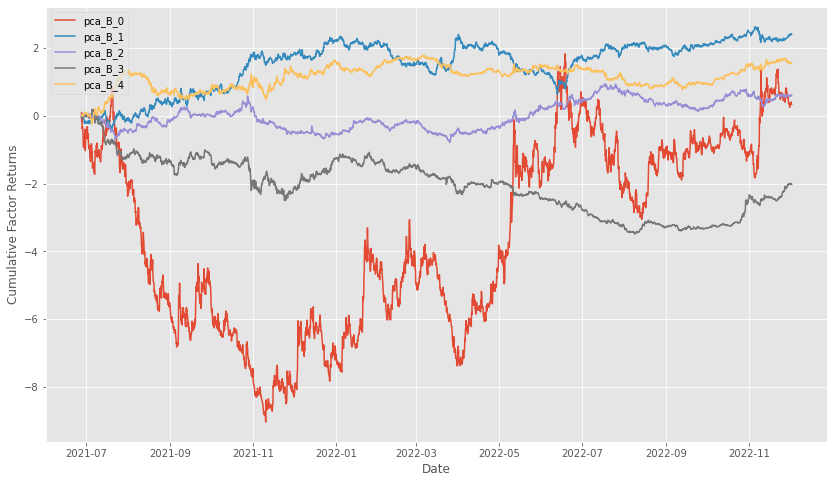

In [80]:
facret_df = pd.DataFrame(index = date_list)

pca_factors = risk_model.factor_betas_.columns.tolist()

for dt in date_list: 
    if dt < start_time:
        continue
    for alp in pca_factors: 
        # 去掉原始数据包含nan，导数pca无法fit的情况。
        if alp in facret[dt]:
            facret_df.at[dt, alp] = facret[dt][alp]

for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

## Choose Alpha Factors
**Alpha因子的contribute**

### 另一种方式获取 factor return
We want to estimate the factor returns of our entire model, including both risk and alpha factors, so we're going to fit a least squares regression model to the risk factors and alpha factor we've come up with, in order to estimate the factor returns. We're going to run the regression for a single time period only—the last one our dataset covers.

In [81]:
factor_list

['nr',
 'dbook',
 'range_pos',
 'price_osci',
 'ma_dif',
 'kdj_k',
 'kdj_j',
 'nr__range',
 'dbook__range',
 'range_pos__range',
 'price_osci__range',
 'ma_dif__range',
 'kdj_k__range',
 'kdj_j__range',
 'nr__std',
 'dbook__std',
 'range_pos__std',
 'price_osci__std',
 'ma_dif__std',
 'kdj_k__std',
 'kdj_j__std',
 'nr__trend_index',
 'dbook__trend_index',
 'range_pos__trend_index',
 'price_osci__trend_index',
 'ma_dif__trend_index',
 'kdj_k__trend_index',
 'kdj_j__trend_index']

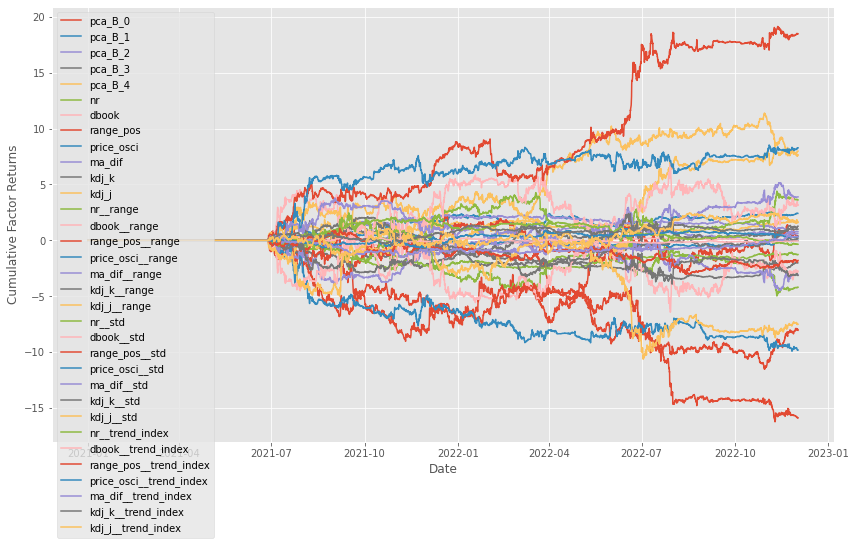

In [82]:
# facret_df = pd.DataFrame(index = date_list)

for dt in date_list: 
    if dt < start_time:
        continue
    for alp in factor_list: 
        if alp in facret[dt]:
            facret_df.at[dt, alp] = facret[dt][alp]

for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

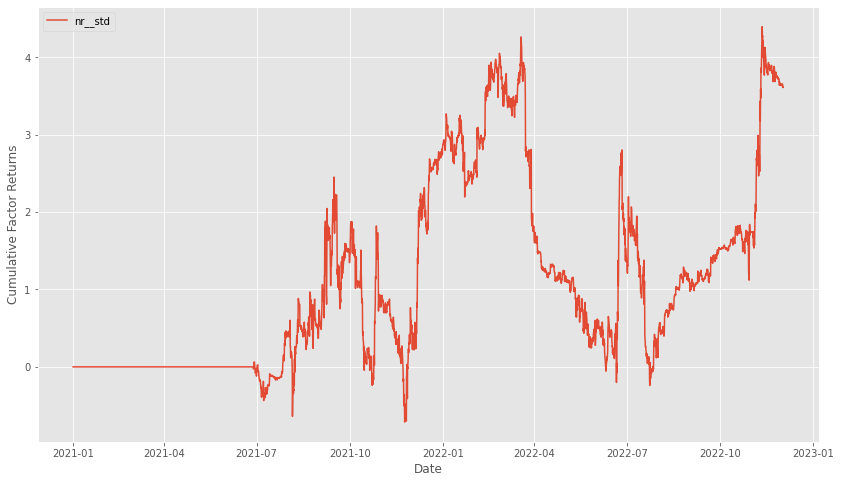

In [83]:
column = "nr__std"
plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

In [84]:
facret[pd.Timestamp("2021-12-01 00:00:00")]

pca_B_0                   -0.028055
pca_B_1                    0.021878
pca_B_2                    0.002412
pca_B_3                    0.008892
pca_B_4                   -0.014962
nr                        -0.027201
dbook                      0.004326
range_pos                 -0.010981
price_osci                 0.020551
ma_dif                    -0.009751
kdj_k                      0.022329
kdj_j                      0.012021
nr__range                 -0.028740
dbook__range               0.463221
range_pos__range           0.052015
price_osci__range         -0.026828
ma_dif__range              0.048078
kdj_k__range               0.001866
kdj_j__range               0.019213
nr__std                    0.035252
dbook__std                -0.466283
range_pos__std            -0.145314
price_osci__std            0.036093
ma_dif__std               -0.055673
kdj_k__std                -0.037809
kdj_j__std                 0.102586
nr__trend_index            0.041383
dbook__trend_index        -0

In [85]:
factor_df_multi.loc[pd.Timestamp('2021-01-01 08:00:00')]

,open,high,low,close,volume,returns,next_returns,nr,dbook,range_pos,...,kdj_k__std,kdj_j__std,nr__trend_index,dbook__trend_index,range_pos__trend_index,price_osci__trend_index,ma_dif__trend_index,kdj_k__trend_index,kdj_j__trend_index,alpha_vector
symbol,,,,,,,,,,,,,,,,,,,,,
BTC_USDT,29107.720000,29454.450000,28900.000000,29341.990000,2.956263e+04,0.008049,-0.004470,1.672435,0.238919,1.672435,...,1.035317,0.796398,1.672435,0.398199,1.672435,1.672435,1.353876,1.672435,1.672435,1.126334
1INCH_USDT,1.238100,1.254100,1.122200,1.173400,8.986698e+06,-0.053252,-0.001619,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAVE_USDT,86.730000,88.756000,84.652000,88.008000,5.827050e+04,0.015087,-0.007863,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADA_USDT,0.179630,0.180960,0.176730,0.179770,8.288452e+07,0.000779,0.005451,1.114957,-0.557478,1.035317,...,0.079640,-0.079640,1.114957,-0.716758,1.035317,1.035317,0.955677,0.955677,1.035317,0.250296
ALGO_USDT,0.357900,0.379300,0.350200,0.367500,2.255654e+07,0.027397,0.112109,-0.637118,0.477839,0.079640,...,-0.238919,-0.318559,-0.637118,-0.079640,-0.159280,-0.637118,-0.637118,-0.318559,-0.318559,-0.412420
ATOM_USDT,6.032000,6.097000,5.872000,6.019000,8.475200e+05,-0.002155,-0.015119,-0.557478,-0.079640,-0.318559,...,0.159280,0.159280,-0.557478,-0.318559,-0.318559,-0.318559,-0.318559,-0.079640,-0.238919,-0.085328
AVAX_USDT,3.184600,3.550000,3.152000,3.519100,1.942419e+06,0.105037,0.041516,-1.353876,-1.592796,-1.353876,...,-1.433516,-1.433516,-1.274236,-1.592796,-1.274236,-1.274236,-1.194597,-1.274236,-1.274236,-1.368098
AXS_USDT,0.523060,0.529580,0.512750,0.527810,8.297330e+05,0.009120,0.070802,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BAL_USDT,14.024000,14.281000,13.727000,14.207000,1.048178e+05,0.013049,0.007039,-1.433516,-0.716758,-1.274236,...,-1.592796,-1.513156,-1.513156,-0.398199,-1.353876,-1.513156,-1.274236,-1.353876,-1.353876,-1.157621


In [86]:
risk_factors = risk_model.factor_betas_.columns.tolist()
risk_factors

['pca_B_0', 'pca_B_1', 'pca_B_2', 'pca_B_3', 'pca_B_4']

In [87]:
factor_list

['nr',
 'dbook',
 'range_pos',
 'price_osci',
 'ma_dif',
 'kdj_k',
 'kdj_j',
 'nr__range',
 'dbook__range',
 'range_pos__range',
 'price_osci__range',
 'ma_dif__range',
 'kdj_k__range',
 'kdj_j__range',
 'nr__std',
 'dbook__std',
 'range_pos__std',
 'price_osci__std',
 'ma_dif__std',
 'kdj_k__std',
 'kdj_j__std',
 'nr__trend_index',
 'dbook__trend_index',
 'range_pos__trend_index',
 'price_osci__trend_index',
 'ma_dif__trend_index',
 'kdj_k__trend_index',
 'kdj_j__trend_index']

In [88]:
pd.DataFrame(facret).T.loc[:pd.Timestamp('2021-12-01 00:00:00'),:][-200:]

,dbook,dbook__range,dbook__std,dbook__trend_index,kdj_j,kdj_j__range,kdj_j__std,kdj_j__trend_index,kdj_k,kdj_k__range,...,pca_B_3,pca_B_4,price_osci,price_osci__range,price_osci__std,price_osci__trend_index,range_pos,range_pos__range,range_pos__std,range_pos__trend_index
2021-10-28 20:00:00,0.041849,0.265371,-0.274774,-0.044862,0.001280,0.009052,-0.137908,-0.057463,-0.067227,0.028549,...,-0.164466,0.077304,-0.015403,-0.032146,0.061045,0.065158,0.071599,-0.029297,0.112893,0.022396
2021-10-29 00:00:00,-0.002666,-0.336917,0.336779,0.000619,0.029678,0.006722,0.023205,-0.048197,-0.003340,-0.099872,...,0.045850,0.017434,0.026992,-0.112328,0.095734,-0.042020,-0.004937,0.053959,-0.065007,-0.014283
2021-10-29 04:00:00,0.023991,0.074882,-0.085679,-0.026056,0.224168,0.255508,-0.208331,-0.175918,0.020628,-0.250002,...,-0.128140,0.078352,-0.082783,-0.212240,0.253217,0.069039,-0.211023,-0.158026,0.101944,0.145646
2021-10-29 08:00:00,0.004281,-0.111787,0.114445,-0.006793,0.111779,-0.093279,0.115682,0.046227,-0.033086,0.169364,...,-0.000686,0.003651,-0.023905,0.075295,-0.073576,0.034659,-0.130808,-0.052192,0.021357,-0.006157
2021-10-29 12:00:00,-0.001422,-0.090140,0.088765,0.005991,-0.046400,0.066924,-0.086376,0.038622,-0.049052,0.038907,...,0.032540,0.003975,-0.015506,-0.053393,0.078315,0.016772,0.082024,-0.031247,0.040759,-0.053793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 08:00:00,-0.007233,-0.221791,0.223874,0.003255,0.057049,-0.017556,0.004778,0.006450,-0.067358,-0.012649,...,0.042588,-0.039999,0.067433,-0.002376,-0.013933,-0.042897,-0.000592,0.034079,0.024109,-0.030126
2021-11-30 12:00:00,-0.005395,-0.137535,0.138150,0.003966,0.089289,-0.158451,0.134601,-0.007710,0.048173,0.013333,...,0.016884,0.008314,-0.011427,0.061580,-0.060779,0.011647,-0.143683,0.037032,-0.010289,0.016132
2021-11-30 16:00:00,-0.007719,0.147855,-0.153107,0.010803,-0.040887,0.130696,-0.190125,0.083097,0.006746,-0.029922,...,0.056396,0.045400,0.028266,0.113689,-0.128355,-0.015855,-0.005523,0.025240,0.045581,-0.078610
2021-11-30 20:00:00,-0.000818,-0.001139,0.003182,0.003394,0.161784,-0.136583,-0.117086,0.050720,-0.027675,0.016013,...,0.025190,-0.037443,-0.010031,0.064443,-0.032140,0.011082,-0.135522,0.206320,0.018060,-0.072380


In [89]:
sharpe_ratio(pd.DataFrame(facret).T, daily_annualization_factor).round(2)[factor_list]

nr                        -0.21
dbook                     -0.01
range_pos                 -0.33
price_osci                -0.00
ma_dif                     0.13
kdj_k                      0.02
kdj_j                      0.31
nr__range                 -0.20
dbook__range              -0.07
range_pos__range          -0.54
price_osci__range         -0.43
ma_dif__range             -0.14
kdj_k__range              -0.16
kdj_j__range               0.29
nr__std                    0.18
dbook__std                 0.08
range_pos__std             0.66
price_osci__std            0.36
ma_dif__std                0.17
kdj_k__std                 0.06
kdj_j__std                -0.28
nr__trend_index           -0.06
dbook__trend_index        -0.02
range_pos__trend_index    -0.14
price_osci__trend_index    0.07
ma_dif__trend_index        0.05
kdj_k__trend_index         0.18
kdj_j__trend_index         0.11
dtype: float64

In [90]:
sharpe_series_2 = sharpe_ratio(pd.DataFrame(facret).T, daily_annualization_factor).round(2)[factor_list]

In [91]:
sharpe_series_2.sort_values()

range_pos__range          -0.54
price_osci__range         -0.43
range_pos                 -0.33
kdj_j__std                -0.28
nr                        -0.21
nr__range                 -0.20
kdj_k__range              -0.16
ma_dif__range             -0.14
range_pos__trend_index    -0.14
dbook__range              -0.07
nr__trend_index           -0.06
dbook__trend_index        -0.02
dbook                     -0.01
price_osci                -0.00
kdj_k                      0.02
ma_dif__trend_index        0.05
kdj_k__std                 0.06
price_osci__trend_index    0.07
dbook__std                 0.08
kdj_j__trend_index         0.11
ma_dif                     0.13
ma_dif__std                0.17
nr__std                    0.18
kdj_k__trend_index         0.18
kdj_j__range               0.29
kdj_j                      0.31
price_osci__std            0.36
range_pos__std             0.66
dtype: float64

In [92]:
pd.DataFrame(facret).T.describe()

,dbook,dbook__range,dbook__std,dbook__trend_index,kdj_j,kdj_j__range,kdj_j__std,kdj_j__trend_index,kdj_k,kdj_k__range,...,pca_B_3,pca_B_4,price_osci,price_osci__range,price_osci__std,price_osci__trend_index,range_pos,range_pos__range,range_pos__std,range_pos__trend_index
count,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,...,3135.000000,3135.000000,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03,4.203000e+03
mean,-4.361995e-06,-6.634471e-04,7.515598e-04,-1.316792e-05,1.820254e-03,1.899239e-03,-1.788467e-03,3.862616e-04,4.510983e-05,-7.457161e-04,...,-0.000646,0.000502,-2.250561e-06,-2.338134e-03,1.967797e-03,8.689343e-05,-1.917376e-03,-3.782024e-03,4.396065e-03,-4.298607e-04
std,8.716981e-03,1.480318e-01,1.477641e-01,8.564722e-03,9.378083e-02,1.043066e-01,1.020741e-01,5.360355e-02,3.833717e-02,7.332845e-02,...,0.030604,0.027528,1.862423e-02,8.537520e-02,8.735974e-02,1.990482e-02,9.336862e-02,1.120740e-01,1.063079e-01,4.718480e-02
min,-5.266863e-02,-1.274597e+00,-1.107057e+00,-6.948292e-02,-9.913457e-01,-7.705696e-01,-8.492949e-01,-5.602160e-01,-3.297625e-01,-6.087276e-01,...,-0.219141,-0.158060,-1.866521e-01,-9.818866e-01,-8.339745e-01,-1.644827e-01,-8.712517e-01,-1.435748e+00,-1.068807e+00,-3.211866e-01
25%,-3.091730e-03,-3.704566e-02,-3.269355e-02,-2.772994e-03,-2.868442e-02,-2.206850e-02,-2.356397e-02,-1.680963e-02,-1.333817e-02,-1.442364e-02,...,-0.013959,-0.013347,-6.156330e-03,-1.935716e-02,-1.507791e-02,-6.965186e-03,-3.393984e-02,-2.517792e-02,-1.940289e-02,-1.788176e-02
50%,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,...,-0.000377,0.000418,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10,-1.000000e-10
75%,3.012352e-03,3.191963e-02,3.626430e-02,2.887142e-03,3.106325e-02,2.618656e-02,2.050618e-02,2.113035e-02,1.253544e-02,1.237710e-02,...,0.012876,0.013554,6.540680e-03,1.416771e-02,1.799721e-02,6.909896e-03,3.073084e-02,2.485995e-02,2.350578e-02,1.505950e-02
max,6.799419e-02,1.112957e+00,1.262573e+00,6.154784e-02,1.046834e+00,9.982732e-01,9.790530e-01,4.595273e-01,3.193193e-01,1.249722e+00,...,0.220588,0.165991,1.661310e-01,8.233067e-01,9.825410e-01,1.499709e-01,9.129347e-01,7.564550e-01,1.111822e+00,4.541252e-01


## Merge Previous Portfolio Holdings 

In order to optimize our portfolio we will use the previous day's holdings to estimate the trade size and transaction costs. In order to keep track of the holdings from the previous day we will include a column to hold the portfolio holdings of the previous day. These holdings of all our assets will be initialized to zero when the backtest first starts.

**初始化第一天的数据，添加previous列，代表之前的holding**

In [93]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

In [94]:
previous_holdings = pd.DataFrame(data = {"symbol" : ["BTC_USDT"], "h.opt.previous" : np.array(0)})
# df0 = factor_df_multi.loc[date_list[0]]

# df0 = df.merge(previous_holdings, how = 'left', on = 'symbol')
# df0 = clean_nas(df)
# df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])

In [95]:
factor_df_multi.loc[date_list[0]]

,open,high,low,close,volume,returns,next_returns,nr,dbook,range_pos,...,kdj_k__std,kdj_j__std,nr__trend_index,dbook__trend_index,range_pos__trend_index,price_osci__trend_index,ma_dif__trend_index,kdj_k__trend_index,kdj_j__trend_index,alpha_vector
symbol,,,,,,,,,,,,,,,,,,,,,
BTC_USDT,7195.23,7234.57,7181.43,7192.65,6650.944,NaN,0.005122,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BCH_USDT,206.29,208.95,204.91,205.94,28290.594,NaN,0.000243,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ETH_USDT,130.24,131.88,129.97,130.64,55654.800,NaN,0.010181,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# all_factors = factor_list
# all_factors

In [97]:
# h0 = df0['h.opt.previous']
# h0

## Build Universe Based on Filters (TODO)

In the cell below, implement the function `get_universe` that creates a stock universe by selecting only those companies that have a market capitalization of at least 1 billion dollars **OR** that are in the previous day's holdings, even if on the current day, the company no longer meets the 1 billion dollar criteria.

When creating the universe, make sure you use the `.copy()` attribute to create a copy of the data. Also, it is very important to make sure that we are not looking at returns when forming the portfolio! to make this impossible, make sure to drop the column containing the daily return.

In [98]:
def get_universe(df):
    """
    Create a stock universe based on filters

    Parameters
    ----------
    df : DataFrame
        All stocks
        
    Returns
    -------
    universe : DataFrame
        Selected stocks based on filters
    """
#     tmp = df.copy()
    tmp = df.copy().drop('next_returns', axis=1)
    # 这里，returns 未使用未来数据，所以保留，
#     universe = tmp[(tmp['IssuerMarketCap'] >= 1e9) | (np.abs(tmp['h.opt.previous']) > 0)]
    # TODO: 可以在此添加过滤条件
    universe = tmp
    
    
    return universe

## Transaction Costs

To get the transaction cost, or slippage, we have to multiply the price change due to market impact by the amount of dollars traded:

$$
\mbox{tcost_{i,t}} = \% \Delta \mbox{price}_{i,t} \times \mbox{trade}_{i,t}
$$

In summation notation it looks like this:  
$$
\mbox{tcost}_{i,t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2
$$  
where
$$
\lambda_{i,t} = \frac{1}{10\times \mbox{ADV}_{i,t}}
$$

Note that since we're dividing by ADV, we'll want to handle cases when ADV is missing or zero.  In those instances, we can set ADV to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid. In the code below if there is no volume information we assume the asset is illiquid.

## Linear price impact of trading

Assume transaction cost is linearly related to the trade size as a fraction of the average daily volume.  Since we won't know the actual daily volume until the day that we're executing, we want to use past data as an estimate for future daily volume.  This would be kind of noisy if we simply use the prior day's daily volume, so we'd prefer a more stable estimate like a 30 day rolling average.

A commonly used **estimate for linear market impact is that if a trade size is 1% of the ADV, this moves the price by 10 basis points (1/10,000).**

$Trade size_{i,t}$ is the fraction of your trade relative to the average dollar volume estimated for that stock, for that day. 

$Trade_{i,t}$ = dollar amount to trade = $h_{t} - h_{t-1}$, which is the new holding of the asset minus the previous holding.

$ADV_{i,t}$: (average dollar volume) is total dollar amount expected to be traded, based on a moving average of historical daily volume.

$TradeSize_{i,t} = \frac{Trade_{i,t}}{ADV_{i,t}}$: The size of the trade relative to the estimated daily volume.

$\% \Delta Price_{i,t}$ = price change due to trading, as a fraction of the original price (it's a percent change).

We'll write out the ratio: change in price divided by the trade size.

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = \frac{10 bps}{1\%}$  

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = \frac{10/10^4}{1/100}$

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = \frac{10^{-3}}{10^{-2}}$

$ \frac{\% \Delta price_{i,t}}{TradeSize_{i,t}} = 10^{-1}$

Now we'll move things around to solve for the change in price.

$\%  \Delta price_{i,t} = 10^{-1} \times TradeSize_{i,t}$

We defined TradeSize to be the Trade divided by ADV.

$\%  \Delta price_{i,t} = 10^{-1} \times \frac{Trade_{i,t}}{ADV_{i,t}}$

Note that Trade is the current position minus the prior day's position

$\%  \Delta price_{i,t} = 10^{-1} \times \frac{h_{i,t} - h_{i,t-1}}{ADV_{i,t}}$

For convenience, we'll combine the constant $10^{-1}$ and $\frac{1}{ADV_{i}}$ and call it lambda $\lambda_{i}$

$\%  \Delta price_{i,t} = \lambda_{i,t} \times (h_{i,t} - h_{i,t-1})$ where $\lambda_{i,t} = 10^{-1}\times \frac{1}{ADV_{i,t}} = \frac{1}{10 \times ADV_{i,t}}$


Note that since we're dividing by $ADV_{i,t}$, we'll want to handle cases when $ADV_{i,t}$ is missing or zero.  In those instances, we can set $ADV_{i,t}$ to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid.

Represent the market impact as $\Delta price_{i} = \lambda_{i} (h_{i,t} - h_{i,t-1})$.  $\lambda_{i}$ incorporates the $ADV_{i,t}$.  Review the lessons to see how to do this.

Note that since we're dividing by $ADV_{i,t}$, we'll want to handle cases when $ADV_{i,t}$ is missing or zero.  In those instances, we can set $ADV_{i,t}$ to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid.

In [99]:
# 这里的 lamda 为，1/(10*ADV)
# 先对nan和0值，赋予默认的1.0e4
# 然后0.1/adv，是对每个symbol计算

def get_lambda(universe, composite_volume_column = 'volume'):
    universe.loc[np.isnan(universe[composite_volume_column]), composite_volume_column] = 1.0e4
    universe.loc[universe[composite_volume_column] == 0, composite_volume_column] = 1.0e4 

    adv = universe[composite_volume_column]
    
    return 0.1 / adv

## Alpha Combination (TODO)

In the code below create a matrix of alpha factors and return it from the function `get_B_alpha`. Create this matrix in the same way you created the matrix of risk factors, i.e. using the `get_formula` and `model_matrix` functions we have defined above. Feel free to go back and look at the previous code.

In [100]:
def model_matrix(formula, data): 
    outcome, predictors = patsy.dmatrices(formula, data)
    # 这里只返回x,即因子矩阵，不返回y值
    return predictors

In [101]:
def get_B_alpha(alpha_factors, universe):
    # TODO: Implement
    formula = get_formula(alpha_factors, "returns")
    B_alpha = model_matrix(formula, universe)
    
    return B_alpha

Now that you have the matrix containing the alpha factors we will combine them by adding its rows. By doing this we will collapse the `B_alpha` matrix into a single alpha vector. We'll multiply by `1e-4` so that the expression of expected portfolio return, $\alpha^T \mathbf{h}$, is in dollar units. 

In [102]:
def get_alpha_vec(B_alpha):
    """
    Create an alpha vecrtor

    Parameters
    ----------        
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    Returns
    -------
    alpha_vec : patsy.design_info.DesignMatrix 
        alpha vector
    """
    
    # TODO: Implement
    scale = 1e-4
    # TODO：更改alpha_vec的计算。
    # 注意，这里的alpha_vec，为简单地把因子矩阵按行相加起来。
#     alpha_vec = scale * np.sum(B_alpha, axis=1)
    alpha_vec = scale * np.mean(B_alpha, axis=1)
    
    return alpha_vec

#### Optional Challenge

You can also try to a more sophisticated method of alpha combination, by choosing the holding for each alpha based on the same metric of its performance, such as the factor returns, or sharpe ratio.  To make this more realistic, you can calculate a rolling average of the sharpe ratio, which is updated for each day.  Remember to only use data that occurs prior to the date of each optimization, and not data that occurs in the future.  Also, since factor returns and sharpe ratios may be negative, consider using a `max` function to give the holdings a lower bound of zero.

# Objective function (TODO)

The objective function is given by:

$$
f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})
$$

Where the terms correspond to: factor risk + idiosyncratic risk - expected portfolio return + transaction costs, respectively. We should also note that $\textbf{Q}^T\textbf{Q}$ is defined to be the same as $\textbf{BFB}^T$.  Review the lessons if you need a refresher of how we get $\textbf{Q}$.

Our objective is to minimize this objective function. To do this, we will use Scipy's optimization function:

`scipy.optimize.fmin_l_bfgs_b(func, initial_guess, func_gradient)`

where:

* **func** : is the function we want to minimize

* **initial_guess** : is out initial guess

* **func_gradient** : is the gradient of the function we want to minimize

So, in order to use the `scipy.optimize.fmin_l_bfgs_b` function we first need to define its parameters.

In the code below implement the function `obj_func(h)` that corresponds to the objective function above that we want to minimize. We will set the risk aversion to be `1.0e-6`.


## Risk Aversion $\kappa$

The risk aversion term is set to target a particular gross market value (GMV), or to target a desired volatility.  In our case, we tried a few values of the risk aversion term, ran the backtest, and calculated the GMV.  Ideally, a quant who is just starting out may have a targeted GMV of 50 million.  A risk aversion term of $10^{-6}$ gets the GMV to be in the tens of millions.  A higher risk aversion term would decrease the GMV, and a lower risk aversion term would increase the GMV, and also the risk.  Note that this isn't necessarily a linear mapping, so in practice, you'll try different values and check the results.

Also, in practice, you'd normally keep the risk aversion term constant, unless your fund is accepting more investor cash, or handling redemptions.  In those instances, the fund size itself changes, so the targeted GMV also changes.  Therefore, we'd adjust the risk aversion term to adjust for the desired GMV. 

Also, note that we would keep this risk aversion term constant, and not adjust it on a daily basis.  Adjusting the risk aversion term too often would result in unecessary trading that isn't informed by the alphas.

#### 因为是最小化，上面的目标函数，等同于，最大化收益  $\mathbf{\alpha}^T \mathbf{h}_t$，最小化交易成本  $(\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})$, 同时最小化PCA风险模型的方差 $\frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t$, $\kappa$ 系数用于控制pca风险模型的影响权重。
#### 注意QQ等于BFB，用PCA模型时，需要替换回去。PCA模型，是经过压缩的维度较低，cov矩阵维度仅为N_Compnents * N_Compnents (而非symbol数)

In [103]:
def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        # TODO: Implement
        f = 0.0
        f += 0.5 * risk_aversion * np.sum( np.matmul(Q, h) ** 2 )
        f += 0.5 * risk_aversion * np.dot(h ** 2, specVar) #since Specific Variance is diagonal, don't have to do matmul
        f -= np.dot(h, alpha_vec)
        f += np.dot( (h - h0) ** 2, Lambda) 
        
        return f
    
    return obj_func

In [104]:
def get_obj_func_pca(h0, risk_aversion, pca_risk_model:RiskModelPCA, alpha_vec, Lambda):     
    def obj_func(h):
        factor_betas = pca_risk_model.factor_betas_
        factor_cov_matrix = pca_risk_model.factor_cov_matrix_
        specVar = pca_risk_model.idio_var_vector_.values.flatten()
        
#         print("get_obj_func_pca", np.shape(h), np.shape(factor_betas), np.shape(factor_cov_matrix), np.shape(specVar))
        # TODO: Implement
        f = 0.0
#         f += 0.5 * risk_aversion * np.sum( np.matmul(Q, h) ** 2 )
        # 使用 hBFBh,替换hQQh
        f += 0.5 * risk_aversion * (np.dot(np.dot(h.T,(np.dot(np.dot(factor_betas,factor_cov_matrix), factor_betas.T))),h))
        f += 0.5 * risk_aversion * np.dot(h ** 2, specVar) #since Specific Variance is diagonal, don't have to do matmul
        f -= np.dot(h, alpha_vec)
        f += np.dot( (h - h0) ** 2, Lambda) 
        
        return f
    
    return obj_func

## Gradient (TODO)

Now that we can generate the objective function using `get_obj_func`, we can now create a similar function with its gradient. The reason we're interested in calculating the gradient is so that we can tell the optimizer in which direction, and how much, it should shift the portfolio holdings in order to improve the objective function (minimize variance, minimize transaction cost, and maximize expected portfolio return).

Before we implement the function we first need to know what the gradient looks like. The gradient, or derivative of the objective function, with respect to the portfolio holdings h, is given by:  

$$
f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}
$$

In the code below, implement the function `grad(h)` that corresponds to the function of the gradient given above.

#### 注意QQ等于BFB，用PCA模型时，需要替换回去。

In [105]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        # TODO: Implement
        g = risk_aversion * (np.matmul(QT, np.matmul(Q,h)) + (specVar * h) ) - alpha_vec + 2 * (h-h0) * Lambda
        return(np.asarray(g))
            
    return grad_func

In [106]:
def get_grad_func_pca(h0, risk_aversion, pca_risk_model, alpha_vec, Lambda):    
    def grad_func(h):
        factor_betas = pca_risk_model.factor_betas_
        factor_cov_matrix = pca_risk_model.factor_cov_matrix_
        specVar = pca_risk_model.idio_var_vector_.values.flatten()
        
        # TODO: Implement
#         g = risk_aversion * (np.matmul(QT, np.matmul(Q,h)) + (specVar * h) ) - alpha_vec + 2 * (h-h0) * Lambda
        # 使用 BFB 替换 QQ
#         print(">>>>>")
#         print("1st part", risk_aversion * (np.dot((np.dot(np.dot(factor_betas,factor_cov_matrix), factor_betas.T)), h)))
#         print("2nd part specVar", specVar.shape)
#         print("2nd part h", h.shape)
#         print("2nd part", (specVar * h))
#         print("3rd part", (np.dot((np.dot(np.dot(factor_betas,factor_cov_matrix), factor_betas.T)), h) + (specVar * h) ))
#         print("4th part", -alpha_vec + 2 * (h-h0) * Lambda)
#         print("5th part", risk_aversion * (np.dot((np.dot(np.dot(factor_betas,factor_cov_matrix), factor_betas.T)), h) + (specVar * h) ))
        g = risk_aversion * (np.dot((np.dot(np.dot(factor_betas,factor_cov_matrix), factor_betas.T)), h) + (specVar * h) ) - alpha_vec + 2 * (h-h0) * Lambda
#         print("g", g)
#         print(">>>>>")
        return(np.asarray(g))
            
    return grad_func

## Optimize (TODO)

Now that we can generate the objective function using `get_obj_func`, and its corresponding gradient using `get_grad_func` we are ready to minimize the objective function using Scipy's optimization function. For this, we will use out initial holdings as our `initial_guess` parameter.

In the cell below, implement the function `get_h_star` that optimizes the objective function. Use the objective function (`obj_func`) and gradient function (`grad_func`) provided within `get_h_star` to optimize the objective function using the `scipy.optimize.fmin_l_bfgs_b` function.

In [107]:


# Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
# QT = Q.transpose()

def get_h_star(risk_aversion, risk_model, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func_pca(h0, risk_aversion, risk_model, alpha_vec, Lambda)
    grad_func = get_grad_func_pca(h0, risk_aversion, risk_model, alpha_vec, Lambda)
    
    # TODO: Implement 
    optimizer_result = scipy.optimize.fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    return optimizer_result[0]

# h_star = get_h_star(risk_aversion, risk_model, alpha_vec, h0, Lambda)

After we have optimized our objective function we can now use, h_star to create our optimal portfolio:

In [108]:
# opt_portfolio = pd.DataFrame(data = {"Symbol" : universe['Symbol'], "h.opt" : h_star})

## Risk Exposures (TODO)

We can also use `h_star` to calculate our portfolio's risk and alpha exposures.

In the cells below implement the functions `get_risk_exposures` and `get_portfolio_alpha_exposure` that calculate the portfolio's risk and alpha exposures, respectively.

In [109]:
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

In [110]:
def get_risk_exposures(B, BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    
    # TODO: Implement
    risk_exposures_calc = np.matmul(BT, h_star)
    risk_exposures = pd.Series(risk_exposures_calc, index = colnames(B))
    
    return risk_exposures

In [111]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    
    # TODO: Implement    
    return pd.Series(np.matmul(B_alpha.transpose(), h_star), index = colnames(B_alpha))

## Transaction Costs (TODO)

We can also use `h_star` to calculate our total transaction costs:
$$
\mbox{tcost} = \sum_i^{N} \lambda_{i} (h_{i,t} - h_{i,t-1})^2
$$

In the cell below, implement the function `get_total_transaction_costs` that calculates the total transaction costs according to the equation above:

In [112]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    # TODO: Implement
    total_transaction_costs = np.sum(np.dot((h_star - h0) ** 2, Lambda))
    
    return total_transaction_costs

## Putting It All Together

We can now take all the above functions we created above and use them to create a single function, `form_optimal_portfolio` that returns the optimal portfolio, the risk and alpha exposures, and the total transactions costs.

### 这里选择因子

In [113]:
# alpha_factors = factor_list
# alpha_factors = ['dbook', 'range_pos']
alpha_factors = sharpe_series[sharpe_series>1].index.tolist()
# alpha_factors = sharpe_series_2[sharpe_series_2>0.1].index.tolist()
alpha_factors

[]

In [114]:
def choose_alpha_factor(facret_df, timestamp, rollling_len=120):
#     ratio_series = sharpe_ratio(facret_df.loc[:timestamp,:][-rollling_len:], daily_annualization_factor).round(2)[factor_list]
    ratio_series = sharpe_ratio(facret_df.loc[:timestamp,:][-rollling_len:], daily_annualization_factor).round(2)[factor_list]

    return ratio_series.sort_values()

In [115]:
# sharpe_ratio(ls_factor_returns.loc[:pd.Timestamp('2022-10-11 00:00:00'),:][-200:], daily_annualization_factor).round(2)[factor_list]


In [116]:
# 选取交易量最大的max_symbol个币
def select_trade_symbol(port, use_all=False):
    if use_all:
        return portfolio
    
    portfolio = port.copy().set_index('symbol')
    # 选取绝对值最大的max_symbol个币
    top_portfolio = portfolio.abs().sort_values(by='h.opt', ascending=False).index.to_list()[:max_symbol]
    # 设置top以外的portfolio为0
    portfolio.loc[~portfolio.index.isin(top_portfolio)] = 0
    return portfolio

In [117]:
def form_optimal_portfolio(df, previous, risk_aversion, risk_model: RiskModelPCA, alpha_factors):
    '''
    把上一次的position，合并到当前df的列里
         symbol  h.opt.previous
      0  BTC_USDT               0
    '''
    df = df.merge(previous, how = 'left', on = 'symbol')
    df = clean_nas(df)  # 去除nan值
    
#     df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
  
    universe = get_universe(df)
#     print("universe", universe)
#     date = str(int(universe['DataDate'][1]))
  
#     all_factors = factors_from_names(list(universe))
#     risk_factors = setdiff(all_factors, alpha_factors)
  
    h0 = universe['h.opt.previous']
#     print("h0 is ", h0)
  
    # TODO:
    # 每次重新计算PCA
    
#     B = model_matrix(get_formula(risk_factors, "SpecRisk"), universe)
    # PCA 模型的B矩阵，为factor_betas
    B = risk_model.factor_betas_
    BT = B.transpose()
#     print("risk factor betas", B)
    
    Lambda = get_lambda(universe)
#     print("Lambda is ", Lambda)
    
    B_alpha = get_B_alpha(alpha_factors, universe)
    
    # 标准化矩阵。
#     scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
#     scaler = StandardScaler(copy=True)
#     scaler.fit(B_alpha)
#     B_alpha_norm = scaler.transform(B_alpha)
#     print('B_alpha is', B_alpha)
#     print('B_alpha_norm is', B_alpha_norm)
    

    # 注意，这里是合并alpha。
    # 把多个alpha因子，合并成一维向量。
#     alpha_vec = get_alpha_vec(B_alpha_norm)
    alpha_vec = get_alpha_vec(B_alpha)
#     print('alpha_vec is', alpha_vec)
  
#     Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
#     QT = Q.transpose()
    
    # 计算持仓。
    h_star = get_h_star(risk_aversion, risk_model, alpha_vec, h0, Lambda) 
    universe = universe.reset_index()
    opt_portfolio = pd.DataFrame(data = {"symbol" : universe['symbol'], "h.opt" : h_star})

    # 获取交易量最大(也即权重最大)的top max_symbol，并将其他置为0
#     opt_portfolio = select_trade_symbol(opt_portfolio)
    opt_portfolio = opt_portfolio.set_index('symbol')
    # 选取绝对值最大的max_symbol个币
    top_portfolio = opt_portfolio.abs().sort_values(by='h.opt', ascending=False).index.to_list()[:max_symbol]
    # 设置top以外的portfolio为0
    opt_portfolio.loc[~opt_portfolio.index.isin(top_portfolio)] = 0
    
    h_star = opt_portfolio.values.flatten()
    
    risk_exposures = get_risk_exposures(B, BT, h_star)
#     print("risk_exposures", risk_exposures)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
#     portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha_norm, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

## Build tradelist

The trade list is the most recent optimal asset holdings minus the previous day's optimal holdings.

In [118]:
def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'symbol')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

## Save optimal holdings as previous optimal holdings.

As we walk through each day, we'll re-use the column for previous holdings by storing the "current" optimal holdings as the "previous" optimal holdings.

In [119]:
# 重命名列名
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

## Run the backtest

Walk through each day, calculating the optimal portfolio holdings and trade list.  This may take some time, but should finish sooner if you've chosen all the optimizations you learned in the lessons.

In [120]:
count=0


In [121]:
factor_df_multi.loc[date]

,open,high,low,close,volume,returns,next_returns,nr,dbook,range_pos,...,kdj_k__std,kdj_j__std,nr__trend_index,dbook__trend_index,range_pos__trend_index,price_osci__trend_index,ma_dif__trend_index,kdj_k__trend_index,kdj_j__trend_index,alpha_vector
symbol,,,,,,,,,,,,,,,,,,,,,
BTC_USDT,16947.000000,16962.700000,16925.300000,16957.500000,6.862131e+03,0.000614,NaN,0.582223,1.513779,0.058222,...,-1.688445,-1.688445,0.815112,1.455556,0.058222,0.582223,1.048001,0.058222,0.058222,-0.405476
1INCH_USDT,0.498700,0.502500,0.498500,0.501400,5.583593e+06,0.005616,NaN,0.232889,1.630223,0.407556,...,0.291111,0.407556,0.116445,1.106223,0.232889,0.232889,0.756889,0.116445,0.291111,0.390921
AAVE_USDT,63.060000,63.830000,63.040000,63.800000,2.955920e+04,0.011735,NaN,0.524000,-0.349334,0.116445,...,-1.630223,-1.630223,0.174667,-0.582223,-0.232889,0.000000,-0.582223,0.000000,-0.174667,-0.671635
ADA_USDT,0.313500,0.314700,0.313200,0.314500,1.313234e+07,0.002870,NaN,-1.455556,-1.164445,-1.572001,...,0.232889,0.174667,-1.455556,-0.698667,-1.455556,-1.455556,-0.407556,-1.455556,-1.455556,-0.563508
ALGO_USDT,0.240800,0.243300,0.240600,0.243100,1.022289e+07,0.009551,NaN,1.164445,-0.058222,1.106223,...,0.582223,1.164445,1.280890,0.232889,0.931556,0.931556,0.524000,0.815112,0.931556,0.719461
ATOM_USDT,10.206000,10.284000,10.194000,10.280000,2.196643e+05,0.007251,NaN,0.756889,-1.280890,0.815112,...,-0.582223,-0.582223,0.640445,-0.931556,1.164445,0.407556,0.349334,0.931556,1.164445,0.043667
AVAX_USDT,13.047000,13.188000,13.033000,13.188000,6.347710e+05,0.010807,NaN,-0.640445,-1.339112,-0.465778,...,-1.572001,-1.572001,-0.582223,-1.048001,-0.407556,-0.465778,-0.524000,-0.349334,-0.407556,-0.906604
AXS_USDT,6.847000,6.889000,6.835000,6.871000,2.276260e+05,0.003505,NaN,-1.513779,1.455556,-1.513779,...,-1.513779,-1.513779,-1.630223,1.280890,-1.630223,-1.572001,-1.572001,-1.630223,-1.630223,-1.151969
BAL_USDT,6.201000,6.233000,6.170000,6.170000,1.505482e+05,-0.004999,NaN,0.989778,1.280890,0.873334,...,-0.465778,-0.465778,1.106223,1.572001,0.989778,0.873334,0.232889,0.873334,0.989778,0.328540


In [122]:
get_universe(factor_df_multi.loc[date])

,open,high,low,close,volume,returns,nr,dbook,range_pos,price_osci,...,kdj_k__std,kdj_j__std,nr__trend_index,dbook__trend_index,range_pos__trend_index,price_osci__trend_index,ma_dif__trend_index,kdj_k__trend_index,kdj_j__trend_index,alpha_vector
symbol,,,,,,,,,,,,,,,,,,,,,
BTC_USDT,16947.000000,16962.700000,16925.300000,16957.500000,6.862131e+03,0.000614,0.582223,1.513779,0.058222,0.174667,...,-1.688445,-1.688445,0.815112,1.455556,0.058222,0.582223,1.048001,0.058222,0.058222,-0.405476
1INCH_USDT,0.498700,0.502500,0.498500,0.501400,5.583593e+06,0.005616,0.232889,1.630223,0.407556,0.407556,...,0.291111,0.407556,0.116445,1.106223,0.232889,0.232889,0.756889,0.116445,0.291111,0.390921
AAVE_USDT,63.060000,63.830000,63.040000,63.800000,2.955920e+04,0.011735,0.524000,-0.349334,0.116445,0.524000,...,-1.630223,-1.630223,0.174667,-0.582223,-0.232889,0.000000,-0.582223,0.000000,-0.174667,-0.671635
ADA_USDT,0.313500,0.314700,0.313200,0.314500,1.313234e+07,0.002870,-1.455556,-1.164445,-1.572001,-1.397334,...,0.232889,0.174667,-1.455556,-0.698667,-1.455556,-1.455556,-0.407556,-1.455556,-1.455556,-0.563508
ALGO_USDT,0.240800,0.243300,0.240600,0.243100,1.022289e+07,0.009551,1.164445,-0.058222,1.106223,0.873334,...,0.582223,1.164445,1.280890,0.232889,0.931556,0.931556,0.524000,0.815112,0.931556,0.719461
ATOM_USDT,10.206000,10.284000,10.194000,10.280000,2.196643e+05,0.007251,0.756889,-1.280890,0.815112,0.465778,...,-0.582223,-0.582223,0.640445,-0.931556,1.164445,0.407556,0.349334,0.931556,1.164445,0.043667
AVAX_USDT,13.047000,13.188000,13.033000,13.188000,6.347710e+05,0.010807,-0.640445,-1.339112,-0.465778,-0.465778,...,-1.572001,-1.572001,-0.582223,-1.048001,-0.407556,-0.465778,-0.524000,-0.349334,-0.407556,-0.906604
AXS_USDT,6.847000,6.889000,6.835000,6.871000,2.276260e+05,0.003505,-1.513779,1.455556,-1.513779,-1.455556,...,-1.513779,-1.513779,-1.630223,1.280890,-1.630223,-1.572001,-1.572001,-1.630223,-1.630223,-1.151969
BAL_USDT,6.201000,6.233000,6.170000,6.170000,1.505482e+05,-0.004999,0.989778,1.280890,0.873334,0.931556,...,-0.465778,-0.465778,1.106223,1.572001,0.989778,0.873334,0.232889,0.873334,0.989778,0.328540


In [123]:
trades = {}
port = {}

# for dt in tqdm(my_dates, desc='Optimizing Portfolio', unit='day'):
for idx,dt in enumerate(date_list):
#     date = dt.strftime('%Y%m%d')
    # TODO: hard code了59
    if dt < start_time:
        continue

    date = dt
    print(date)
    
    # 可能有些symbol在某个时间点并不存在。
    available_symbol_list = factor_df_multi.loc[date].index.tolist()
    
    # 
    win_start_idx = 0
    if idx > len_pca_dates:
        win_start_idx = idx - len_pca_dates + 1
    
    # 包含pca模型
    risk_model = RiskModelPCA(num_factor_exposures)
    # 这里是回测，pca模型使用直到当前date的所有close数据
    risk_model.fit(total_close_df.loc[date_list[win_start_idx]:date][available_symbol_list])
    
    # 选取alpha factor
    # facret 里OLS计算的时候，最后一条数据用到了"next_return"，即未来数据，所以这里提前一天。
    # 使用facret的方式，或者ls_factor_returns的方式
#     alpha_factors = choose_alpha_factor(pd.DataFrame(facret).T, date_list[idx-1], 120)
    alpha_factors = choose_alpha_factor(ls_factor_returns, date_list[idx-1], len_dates)
    # .sort_values(ascending=False) 从大到小排序
    # 注意，这里最多取5个factor
    alpha_factors = alpha_factors[alpha_factors>0].sort_values(ascending=False).index.tolist()[:max_factors]
#     print("alpha factors", alpha_factors)
    if len(alpha_factors) == 0:
        continue
    
#     print("previous_holdings", previous_holdings)
    result = form_optimal_portfolio(factor_df_multi.loc[date], previous_holdings, risk_aversion, risk_model, alpha_factors)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    # 更新持仓，进行下次迭代
    previous_holdings = convert_to_previous(result)
    
#     break

2021-01-01 00:00:00
2021-01-01 04:00:00
2021-01-01 08:00:00
2021-01-01 12:00:00
2021-01-01 16:00:00
2021-01-01 20:00:00
2021-01-02 00:00:00
2021-01-02 04:00:00
2021-01-02 08:00:00
2021-01-02 12:00:00
2021-01-02 16:00:00
2021-01-02 20:00:00
2021-01-03 00:00:00
2021-01-03 04:00:00
2021-01-03 08:00:00
2021-01-03 12:00:00
2021-01-03 16:00:00
2021-01-03 20:00:00
2021-01-04 00:00:00
2021-01-04 04:00:00
2021-01-04 08:00:00
2021-01-04 12:00:00
2021-01-04 16:00:00
2021-01-04 20:00:00
2021-01-05 00:00:00
2021-01-05 04:00:00
2021-01-05 08:00:00
2021-01-05 12:00:00
2021-01-05 16:00:00
2021-01-05 20:00:00
2021-01-06 00:00:00
2021-01-06 04:00:00
2021-01-06 08:00:00
2021-01-06 12:00:00
2021-01-06 16:00:00
2021-01-06 20:00:00
2021-01-07 00:00:00
2021-01-07 04:00:00
2021-01-07 08:00:00
2021-01-07 12:00:00
2021-01-07 16:00:00
2021-01-07 20:00:00
2021-01-08 00:00:00
2021-01-08 04:00:00
2021-01-08 08:00:00
2021-01-08 12:00:00
2021-01-08 16:00:00
2021-01-08 20:00:00
2021-01-09 00:00:00
2021-01-09 04:00:00


2021-03-11 04:00:00
2021-03-11 08:00:00
2021-03-11 12:00:00
2021-03-11 16:00:00
2021-03-11 20:00:00
2021-03-12 00:00:00
2021-03-12 04:00:00
2021-03-12 08:00:00
2021-03-12 12:00:00
2021-03-12 16:00:00
2021-03-12 20:00:00
2021-03-13 00:00:00
2021-03-13 04:00:00
2021-03-13 08:00:00
2021-03-13 12:00:00
2021-03-13 16:00:00
2021-03-13 20:00:00
2021-03-14 00:00:00
2021-03-14 04:00:00
2021-03-14 08:00:00
2021-03-14 12:00:00
2021-03-14 16:00:00
2021-03-14 20:00:00
2021-03-15 00:00:00
2021-03-15 04:00:00
2021-03-15 08:00:00
2021-03-15 12:00:00
2021-03-15 16:00:00
2021-03-15 20:00:00
2021-03-16 00:00:00
2021-03-16 04:00:00
2021-03-16 08:00:00
2021-03-16 12:00:00
2021-03-16 16:00:00
2021-03-16 20:00:00
2021-03-17 00:00:00
2021-03-17 04:00:00
2021-03-17 08:00:00
2021-03-17 12:00:00
2021-03-17 16:00:00
2021-03-17 20:00:00
2021-03-18 00:00:00
2021-03-18 04:00:00
2021-03-18 08:00:00
2021-03-18 12:00:00
2021-03-18 16:00:00
2021-03-18 20:00:00
2021-03-19 00:00:00
2021-03-19 04:00:00
2021-03-19 08:00:00


2021-05-19 00:00:00
2021-05-19 04:00:00
2021-05-19 08:00:00
2021-05-19 12:00:00
2021-05-19 16:00:00
2021-05-19 20:00:00
2021-05-20 00:00:00
2021-05-20 04:00:00
2021-05-20 08:00:00
2021-05-20 12:00:00
2021-05-20 16:00:00
2021-05-20 20:00:00
2021-05-21 00:00:00
2021-05-21 04:00:00
2021-05-21 08:00:00
2021-05-21 12:00:00
2021-05-21 16:00:00
2021-05-21 20:00:00
2021-05-22 00:00:00
2021-05-22 04:00:00
2021-05-22 08:00:00
2021-05-22 12:00:00
2021-05-22 16:00:00
2021-05-22 20:00:00
2021-05-23 00:00:00
2021-05-23 04:00:00
2021-05-23 08:00:00
2021-05-23 12:00:00
2021-05-23 16:00:00
2021-05-23 20:00:00
2021-05-24 00:00:00
2021-05-24 04:00:00
2021-05-24 08:00:00
2021-05-24 12:00:00
2021-05-24 16:00:00
2021-05-24 20:00:00
2021-05-25 00:00:00
2021-05-25 04:00:00
2021-05-25 08:00:00
2021-05-25 12:00:00
2021-05-25 16:00:00
2021-05-25 20:00:00
2021-05-26 00:00:00
2021-05-26 04:00:00
2021-05-26 08:00:00
2021-05-26 12:00:00
2021-05-26 16:00:00
2021-05-26 20:00:00
2021-05-27 00:00:00
2021-05-27 04:00:00


2021-07-26 16:00:00
2021-07-26 20:00:00
2021-07-27 00:00:00
2021-07-27 04:00:00
2021-07-27 08:00:00
2021-07-27 12:00:00
2021-07-27 16:00:00
2021-07-27 20:00:00
2021-07-28 00:00:00
2021-07-28 04:00:00
2021-07-28 08:00:00
2021-07-28 12:00:00
2021-07-28 16:00:00
2021-07-28 20:00:00
2021-07-29 00:00:00
2021-07-29 04:00:00
2021-07-29 08:00:00
2021-07-29 12:00:00
2021-07-29 16:00:00
2021-07-29 20:00:00
2021-07-30 00:00:00
2021-07-30 04:00:00
2021-07-30 08:00:00
2021-07-30 12:00:00
2021-07-30 16:00:00
2021-07-30 20:00:00
2021-07-31 00:00:00
2021-07-31 04:00:00
2021-07-31 08:00:00
2021-07-31 12:00:00
2021-07-31 16:00:00
2021-07-31 20:00:00
2021-08-01 00:00:00
2021-08-01 04:00:00
2021-08-01 08:00:00
2021-08-01 12:00:00
2021-08-01 16:00:00
2021-08-01 20:00:00
2021-08-02 00:00:00
2021-08-02 04:00:00
2021-08-02 08:00:00
2021-08-02 12:00:00
2021-08-02 16:00:00
2021-08-02 20:00:00
2021-08-03 00:00:00
2021-08-03 04:00:00
2021-08-03 08:00:00
2021-08-03 12:00:00
2021-08-03 16:00:00
2021-08-03 20:00:00


2021-10-03 12:00:00
2021-10-03 16:00:00
2021-10-03 20:00:00
2021-10-04 00:00:00
2021-10-04 04:00:00
2021-10-04 08:00:00
2021-10-04 12:00:00
2021-10-04 16:00:00
2021-10-04 20:00:00
2021-10-05 00:00:00
2021-10-05 04:00:00
2021-10-05 08:00:00
2021-10-05 12:00:00
2021-10-05 16:00:00
2021-10-05 20:00:00
2021-10-06 00:00:00
2021-10-06 04:00:00
2021-10-06 08:00:00
2021-10-06 12:00:00
2021-10-06 16:00:00
2021-10-06 20:00:00
2021-10-07 00:00:00
2021-10-07 04:00:00
2021-10-07 08:00:00
2021-10-07 12:00:00
2021-10-07 16:00:00
2021-10-07 20:00:00
2021-10-08 00:00:00
2021-10-08 04:00:00
2021-10-08 08:00:00
2021-10-08 12:00:00
2021-10-08 16:00:00
2021-10-08 20:00:00
2021-10-09 00:00:00
2021-10-09 04:00:00
2021-10-09 08:00:00
2021-10-09 12:00:00
2021-10-09 16:00:00
2021-10-09 20:00:00
2021-10-10 00:00:00
2021-10-10 04:00:00
2021-10-10 08:00:00
2021-10-10 12:00:00
2021-10-10 16:00:00
2021-10-10 20:00:00
2021-10-11 00:00:00
2021-10-11 04:00:00
2021-10-11 08:00:00
2021-10-11 12:00:00
2021-10-11 16:00:00


2021-12-10 20:00:00
2021-12-11 00:00:00
2021-12-11 04:00:00
2021-12-11 08:00:00
2021-12-11 12:00:00
2021-12-11 16:00:00
2021-12-11 20:00:00
2021-12-12 00:00:00
2021-12-12 04:00:00
2021-12-12 08:00:00
2021-12-12 12:00:00
2021-12-12 16:00:00
2021-12-12 20:00:00
2021-12-13 00:00:00
2021-12-13 04:00:00
2021-12-13 08:00:00
2021-12-13 12:00:00
2021-12-13 16:00:00
2021-12-13 20:00:00
2021-12-14 00:00:00
2021-12-14 04:00:00
2021-12-14 08:00:00
2021-12-14 12:00:00
2021-12-14 16:00:00
2021-12-14 20:00:00
2021-12-15 00:00:00
2021-12-15 04:00:00
2021-12-15 08:00:00
2021-12-15 12:00:00
2021-12-15 16:00:00
2021-12-15 20:00:00
2021-12-16 00:00:00
2021-12-16 04:00:00
2021-12-16 08:00:00
2021-12-16 12:00:00
2021-12-16 16:00:00
2021-12-16 20:00:00
2021-12-17 00:00:00
2021-12-17 04:00:00
2021-12-17 08:00:00
2021-12-17 12:00:00
2021-12-17 16:00:00
2021-12-17 20:00:00
2021-12-18 00:00:00
2021-12-18 04:00:00
2021-12-18 08:00:00
2021-12-18 12:00:00
2021-12-18 16:00:00
2021-12-18 20:00:00
2021-12-19 00:00:00


2022-02-17 12:00:00
2022-02-17 16:00:00
2022-02-17 20:00:00
2022-02-18 00:00:00
2022-02-18 04:00:00
2022-02-18 08:00:00
2022-02-18 12:00:00
2022-02-18 16:00:00
2022-02-18 20:00:00
2022-02-19 00:00:00
2022-02-19 04:00:00
2022-02-19 08:00:00
2022-02-19 12:00:00
2022-02-19 16:00:00
2022-02-19 20:00:00
2022-02-20 00:00:00
2022-02-20 04:00:00
2022-02-20 08:00:00
2022-02-20 12:00:00
2022-02-20 16:00:00
2022-02-20 20:00:00
2022-02-21 00:00:00
2022-02-21 04:00:00
2022-02-21 08:00:00
2022-02-21 12:00:00
2022-02-21 16:00:00
2022-02-21 20:00:00
2022-02-22 00:00:00
2022-02-22 04:00:00
2022-02-22 08:00:00
2022-02-22 12:00:00
2022-02-22 16:00:00
2022-02-22 20:00:00
2022-02-23 00:00:00
2022-02-23 04:00:00
2022-02-23 08:00:00
2022-02-23 12:00:00
2022-02-23 16:00:00
2022-02-23 20:00:00
2022-02-24 00:00:00
2022-02-24 04:00:00
2022-02-24 08:00:00
2022-02-24 12:00:00
2022-02-24 16:00:00
2022-02-24 20:00:00
2022-02-25 00:00:00
2022-02-25 04:00:00
2022-02-25 08:00:00
2022-02-25 12:00:00
2022-02-25 16:00:00


2022-04-27 00:00:00
2022-04-27 04:00:00
2022-04-27 08:00:00
2022-04-27 12:00:00
2022-04-27 16:00:00
2022-04-27 20:00:00
2022-04-28 00:00:00
2022-04-28 04:00:00
2022-04-28 08:00:00
2022-04-28 12:00:00
2022-04-28 16:00:00
2022-04-28 20:00:00
2022-04-29 00:00:00
2022-04-29 04:00:00
2022-04-29 08:00:00
2022-04-29 12:00:00
2022-04-29 16:00:00
2022-04-29 20:00:00
2022-04-30 00:00:00
2022-04-30 04:00:00
2022-04-30 08:00:00
2022-04-30 12:00:00
2022-04-30 16:00:00
2022-04-30 20:00:00
2022-05-01 00:00:00
2022-05-01 04:00:00
2022-05-01 08:00:00
2022-05-01 12:00:00
2022-05-01 16:00:00
2022-05-01 20:00:00
2022-05-02 00:00:00
2022-05-02 04:00:00
2022-05-02 08:00:00
2022-05-02 12:00:00
2022-05-02 16:00:00
2022-05-02 20:00:00
2022-05-03 00:00:00
2022-05-03 04:00:00
2022-05-03 08:00:00
2022-05-03 12:00:00
2022-05-03 16:00:00
2022-05-03 20:00:00
2022-05-04 00:00:00
2022-05-04 04:00:00
2022-05-04 08:00:00
2022-05-04 12:00:00
2022-05-04 16:00:00
2022-05-04 20:00:00
2022-05-05 00:00:00
2022-05-05 04:00:00


2022-07-04 16:00:00
2022-07-04 20:00:00
2022-07-05 00:00:00
2022-07-05 04:00:00
2022-07-05 08:00:00
2022-07-05 12:00:00
2022-07-05 16:00:00
2022-07-05 20:00:00
2022-07-06 00:00:00
2022-07-06 04:00:00
2022-07-06 08:00:00
2022-07-06 12:00:00
2022-07-06 16:00:00
2022-07-06 20:00:00
2022-07-07 00:00:00
2022-07-07 04:00:00
2022-07-07 08:00:00
2022-07-07 12:00:00
2022-07-07 16:00:00
2022-07-07 20:00:00
2022-07-08 00:00:00
2022-07-08 04:00:00
2022-07-08 08:00:00
2022-07-08 12:00:00
2022-07-08 16:00:00
2022-07-08 20:00:00
2022-07-09 00:00:00
2022-07-09 04:00:00
2022-07-09 08:00:00
2022-07-09 12:00:00
2022-07-09 16:00:00
2022-07-09 20:00:00
2022-07-10 00:00:00
2022-07-10 04:00:00
2022-07-10 08:00:00
2022-07-10 12:00:00
2022-07-10 16:00:00
2022-07-10 20:00:00
2022-07-11 00:00:00
2022-07-11 04:00:00
2022-07-11 08:00:00
2022-07-11 12:00:00
2022-07-11 16:00:00
2022-07-11 20:00:00
2022-07-12 00:00:00
2022-07-12 04:00:00
2022-07-12 08:00:00
2022-07-12 12:00:00
2022-07-12 16:00:00
2022-07-12 20:00:00


2022-09-11 04:00:00
2022-09-11 08:00:00
2022-09-11 12:00:00
2022-09-11 16:00:00
2022-09-11 20:00:00
2022-09-12 00:00:00
2022-09-12 04:00:00
2022-09-12 08:00:00
2022-09-12 12:00:00
2022-09-12 16:00:00
2022-09-12 20:00:00
2022-09-13 00:00:00
2022-09-13 04:00:00
2022-09-13 08:00:00
2022-09-13 12:00:00
2022-09-13 16:00:00
2022-09-13 20:00:00
2022-09-14 00:00:00
2022-09-14 04:00:00
2022-09-14 08:00:00
2022-09-14 12:00:00
2022-09-14 16:00:00
2022-09-14 20:00:00
2022-09-15 00:00:00
2022-09-15 04:00:00
2022-09-15 08:00:00
2022-09-15 12:00:00
2022-09-15 16:00:00
2022-09-15 20:00:00
2022-09-16 00:00:00
2022-09-16 04:00:00
2022-09-16 08:00:00
2022-09-16 12:00:00
2022-09-16 16:00:00
2022-09-16 20:00:00
2022-09-17 00:00:00
2022-09-17 04:00:00
2022-09-17 08:00:00
2022-09-17 12:00:00
2022-09-17 16:00:00
2022-09-17 20:00:00
2022-09-18 00:00:00
2022-09-18 04:00:00
2022-09-18 08:00:00
2022-09-18 12:00:00
2022-09-18 16:00:00
2022-09-18 20:00:00
2022-09-19 00:00:00
2022-09-19 04:00:00
2022-09-19 08:00:00


2022-11-18 16:00:00
2022-11-18 20:00:00
2022-11-19 00:00:00
2022-11-19 04:00:00
2022-11-19 08:00:00
2022-11-19 12:00:00
2022-11-19 16:00:00
2022-11-19 20:00:00
2022-11-20 00:00:00
2022-11-20 04:00:00
2022-11-20 08:00:00
2022-11-20 12:00:00
2022-11-20 16:00:00
2022-11-20 20:00:00
2022-11-21 00:00:00
2022-11-21 04:00:00
2022-11-21 08:00:00
2022-11-21 12:00:00
2022-11-21 16:00:00
2022-11-21 20:00:00
2022-11-22 00:00:00
2022-11-22 04:00:00
2022-11-22 08:00:00
2022-11-22 12:00:00
2022-11-22 16:00:00
2022-11-22 20:00:00
2022-11-23 00:00:00
2022-11-23 04:00:00
2022-11-23 08:00:00
2022-11-23 12:00:00
2022-11-23 16:00:00
2022-11-23 20:00:00
2022-11-24 00:00:00
2022-11-24 04:00:00
2022-11-24 08:00:00
2022-11-24 12:00:00
2022-11-24 16:00:00
2022-11-24 20:00:00
2022-11-25 00:00:00
2022-11-25 04:00:00
2022-11-25 08:00:00
2022-11-25 12:00:00
2022-11-25 16:00:00
2022-11-25 20:00:00
2022-11-26 00:00:00
2022-11-26 04:00:00
2022-11-26 08:00:00
2022-11-26 12:00:00
2022-11-26 16:00:00
2022-11-26 20:00:00


## Profit-and-Loss (PnL) attribution (TODO)

Profit and Loss is the aggregate realized daily returns of the assets, weighted by the optimal portfolio holdings chosen, and summed up to get the portfolio's profit and loss.

The PnL attributed to the alpha factors equals the factor returns times factor exposures for the alpha factors.  

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Similarly, the PnL attributed to the risk factors equals the factor returns times factor exposures of the risk factors.

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In the code below, in the function `build_pnl_attribution` calculate the PnL attributed to the alpha factors, the PnL attributed to the risk factors, and attribution to cost. 

**注意，这里计算的是alpha/risk因子的attribution。而非实际的PNL。因子回报facret，是前面通过OLS线性回归计算的因子权重**

In [124]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
#     print("v",v)
#     print("w",w)
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

count=0
def build_pnl_attribution(): 
    
    cost = 0.001
    df = pd.DataFrame(index = date_list)
    
#     for dt in my_dates:
    for date in date_list:
#         date = dt.strftime('%Y%m%d')

        if date < start_time:
            continue
            
#         global count   
#         count=count+1
#         if count > 10:
#             print('count', count)
#             return
        if date not in port.keys():
            continue

#         print(date)
        p = port[date]
#         fr = facret[date]
        fr = facret_df.loc[date]
    
#         print("fr", fr)
#         print('alpha exposure', p['alpha.exposures'])
#         print('risk exposure', p['risk.exposures'])
        
        mf = p['opt.portfolio'].merge(factor_df_multi.loc[date], how = 'left', on = "symbol")        
        mf['next_returns'] = wins(mf['next_returns'], -0.5, 0.5)
        
        daily_ret = np.sum(mf['h.opt'] * mf['next_returns'])
        df.at[date,"daily.pnl"] = daily_ret
#         if daily_ret>0:
#             df.at[date,"daily.pnl"] = daily_ret*(1-cost)
#         else:
#             df.at[date,"daily.pnl"] = daily_ret*(1+cost)
        
        # TODO: Implement
    
        df.at[date,"attribution.alpha.pnl"] = partial_dot_product(fr, p['alpha.exposures'])
        
        # TODO: 重要，这里risk计算不准确！！！！
        # 需要获取PCA的factor return(fr),，并重新命名与p['risk.exposures']相同的列名。
        df.at[date,"attribution.risk.pnl"] = partial_dot_product(fr, p['risk.exposures'])
        
        df.at[date,"attribution.cost"] = p['total.cost']
        
    return df

alpha factors ['kdj_k', 'kdj_j__trend_index', 'range_pos__trend_index', 'kdj_k__trend_index', 'range_pos']


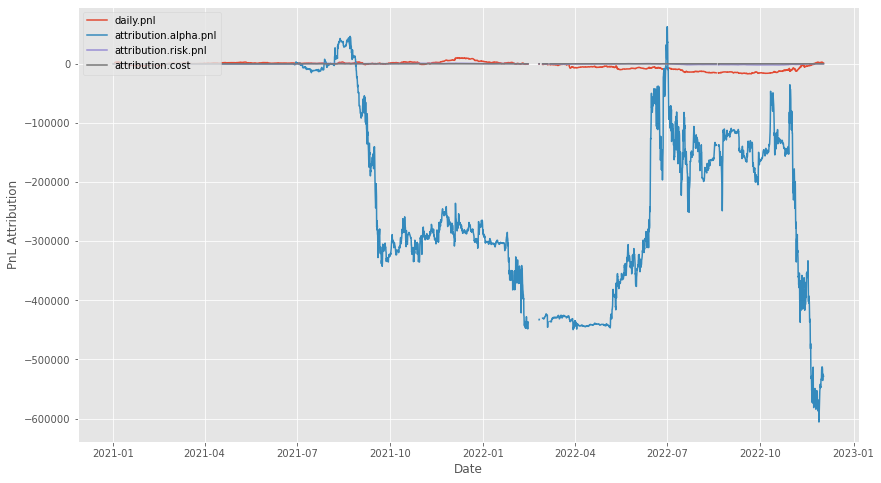

In [125]:
print("alpha factors", alpha_factors)
attr = build_pnl_attribution()

for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [126]:
port[pd.Timestamp('2022-10-10 00:00:00')]['opt.portfolio']


,h.opt
symbol,
BTC_USDT,0.000000
1INCH_USDT,2131.273264
AAVE_USDT,0.000000
ADA_USDT,-1301.364383
ALGO_USDT,2524.976673
ATOM_USDT,1148.608686
AVAX_USDT,0.000000
AXS_USDT,0.000000
BAL_USDT,0.000000


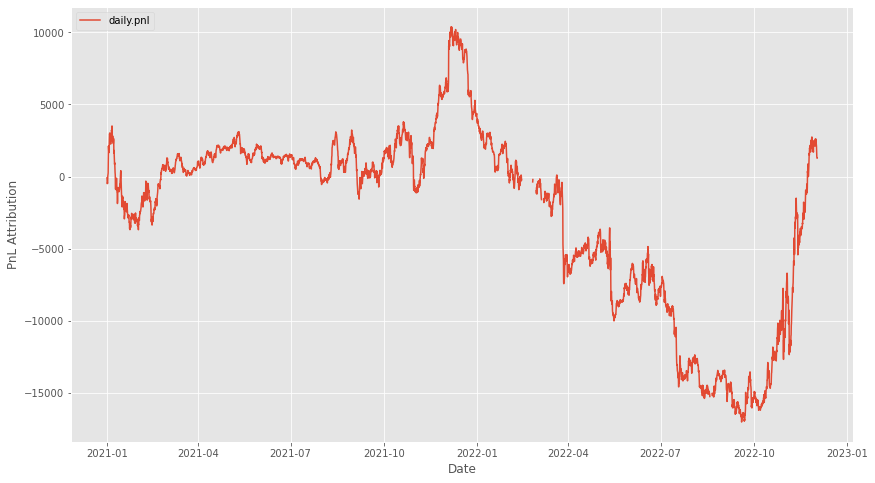

In [127]:
# 值输出risk.pnl
# column='attribution.risk.pnl'
# column='attribution.alpha.pnl'
column='daily.pnl'
plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

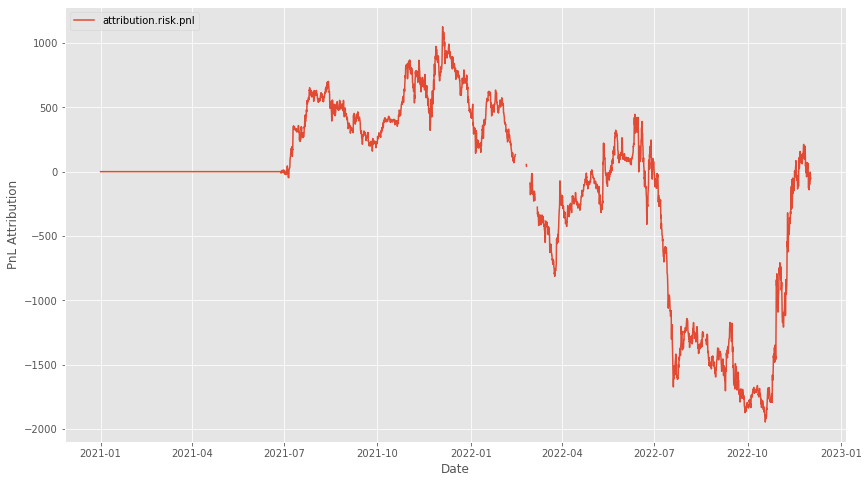

In [128]:
# 值输出risk.pnl
column='attribution.risk.pnl'
# column='attribution.alpha.pnl'
# column='daily.pnl'
plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

## Build portfolio characteristics (TODO)
Calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.

In the code below, in the function `build_portfolio_characteristics` calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.  

In [129]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = date_list)
    
    for dt in date_list:
        date = dt
        
        # TODO: hard code了59
        if dt < start_time:
            continue
            
        if date not in port.keys():
            continue
  
        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']
        
        # TODO: Implement
        
        df.at[dt,"long"] = h[h > 0].sum()
        df.at[dt,"short"] = h[h < 0].sum()
        df.at[dt,"net"] = h.sum()
        df.at[dt,"gmv"] = h.abs().sum()
        df.at[dt,"traded"] = tradelist['h.opt'].sum() - tradelist['h.opt.previous'].sum()
        
    return df

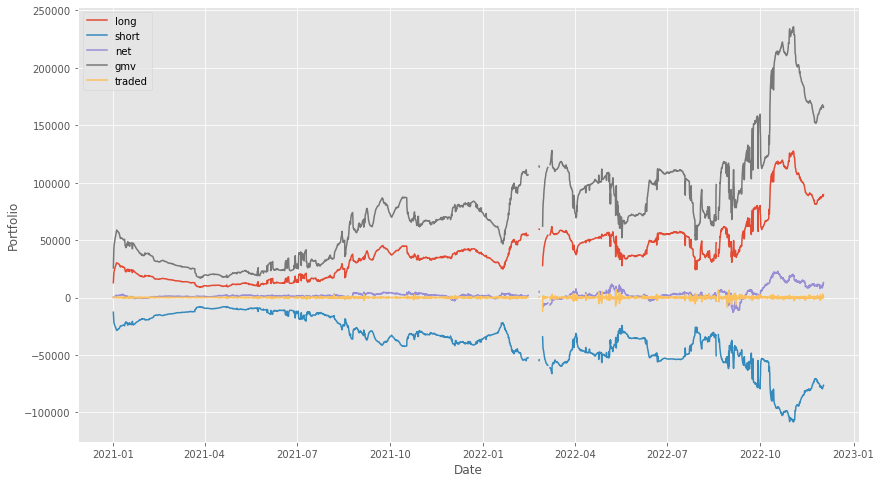

In [130]:
pchar = build_portfolio_characteristics()

for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()